# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre-processing</a></div><div class="lev2 toc-item"><a href="#Data-import" data-toc-modified-id="Data-import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data import</a></div><div class="lev2 toc-item"><a href="#Remove-questionable-data" data-toc-modified-id="Remove-questionable-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Remove questionable data</a></div><div class="lev2 toc-item"><a href="#Create-X-and-Y-arrays-for-each-school-district" data-toc-modified-id="Create-X-and-Y-arrays-for-each-school-district-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create X and Y arrays for each school district</a></div><div class="lev2 toc-item"><a href="#Boundaries" data-toc-modified-id="Boundaries-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Boundaries</a></div><div class="lev1 toc-item"><a href="#Model-with-fixed-hyperparameters" data-toc-modified-id="Model-with-fixed-hyperparameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model with fixed hyperparameters</a></div><div class="lev2 toc-item"><a href="#Fit-GPs-for-each-district" data-toc-modified-id="Fit-GPs-for-each-district-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit GPs for each district</a></div><div class="lev2 toc-item"><a href="#2GP-posterior" data-toc-modified-id="2GP-posterior-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2GP posterior</a></div><div class="lev2 toc-item"><a href="#Inverse-Variance" data-toc-modified-id="Inverse-Variance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inverse-Variance</a></div><div class="lev1 toc-item"><a href="#Incorporating-covariates" data-toc-modified-id="Incorporating-covariates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Incorporating covariates</a></div><div class="lev2 toc-item"><a href="#Linear-regression-ignoring-spatial-correlation" data-toc-modified-id="Linear-regression-ignoring-spatial-correlation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression ignoring spatial correlation</a></div><div class="lev2 toc-item"><a href="#Ridge-regression" data-toc-modified-id="Ridge-regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ridge regression</a></div><div class="lev2 toc-item"><a href="#Fitting-GPs-to-residuals" data-toc-modified-id="Fitting-GPs-to-residuals-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Fitting GPs to residuals</a></div><div class="lev1 toc-item"><a href="#Hyperparameters" data-toc-modified-id="Hyperparameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameters</a></div><div class="lev1 toc-item"><a href="#Covariates-and-hyperparameters" data-toc-modified-id="Covariates-and-hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Covariates and hyperparameters</a></div><div class="lev2 toc-item"><a href="#Fitting-GP-to-ridge-residuals" data-toc-modified-id="Fitting-GP-to-ridge-residuals-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fitting GP to ridge residuals</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data pre-processing
## Data import

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])

In [3]:
print(names(Tucson_sales))

Symbol[:x,:ADDRESS,:ADPARCEL_,:ADPARCEL_I,:ADR_ID,:AD_STREET,:AD_SUFFIX,:ANGLE,:AREA,:CITY_ID,:CODE,:DATE_ENTER,:LAT,:LON,:PERIMETER,:POLYGONID,:SCALE,:SOURCE,:STATUS,:STREET,:STREET_DIR,:STREET_IDX,:STREET_NAM,:STREET_NO,:SUFFIX_DIR,:TILE_NAME,:X_HPGN,:Y_HPGN,:ZIPCITY,:ZIPCODE,:geometry,:SequenceNum,:SaleDate,:SalePrice,:PropertyType,:IntendedUse,:Deed,:Financing,:ValidationDescription,:BuyerSellerRelated,:Solar,:PersonalProperty,:PartialInterest,:RecordingDate,:TAXYEAR,:SFRCONDO,:COMPLEXID,:INSPECTION,:CLASS,:STORIES,:ROOMS,:QUALITY,:WALLS,:ROOF,:HEAT,:COOL,:BATHFIXTUR,:PATIO,:PATIONUMBE,:CONDITION,:SQFT,:YEAR,:GARAGE,:GARAGECAPA,:POOLAREA,:MAIN,:CONTROL,:ACTUAL,:LASTACTION,:VALUATIONC,:APPLICATION,:ENHANCEMEN,:ADJUSTMENT,:APPRAISER,:PHONE,:TAXYEARAdds,:BLDG_ID,:SFRCONDOAdds,:OCCUPANCY,:DETACHED,:CLASSAdds,:QUALITYAdds,:YEARAdds,:SQFTAdds,:STORIESAdds,:HEATAdds,:COOLAdds,:WALLSAdds,:ROOFAdds,:GARAGEAdds,:GARAGECAPAAdds,:PATIOAdds,:PATIONUMBEAdds,:MAINFCV,:ENHANCEMENAdds,:VALUATIONCAd

In [4]:
size(Tucson_sales)

(40989,109)

## Remove questionable data

In [5]:
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end
mean(believable)

0.5416819146600308

In [7]:
recent = Tucson_sales[:,:SaleDate].>201500
recent_in_believable = Tucson_sales[believable,:SaleDate].>201500
sum(recent & believable)

5349

## Create X and Y arrays for each school district

In [8]:
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
recent_Y_dict=Dict{String, Vector{Float64}}()
recent_X_dict=Dict{String, Array{Float64,2}}()

  likely near In[8]:1
  likely near In[8]:2
  likely near In[8]:3
  likely near In[8]:4


Dict{String,Array{Float64,2}} with 0 entries

In [9]:
schdistrs = unique(Tucson_sales[:,:SchDistr])

6-element DataArrays.DataArray{String,1}:
 "Flowing Wells Unified District"
 "Tucson Unified District"       
 "Amphitheater Unified District" 
 "Sunnyside Unified District"    
 "Vail Unified District"         
 "Tanque Verde Unified District" 

In [17]:
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Matrix(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]])
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end

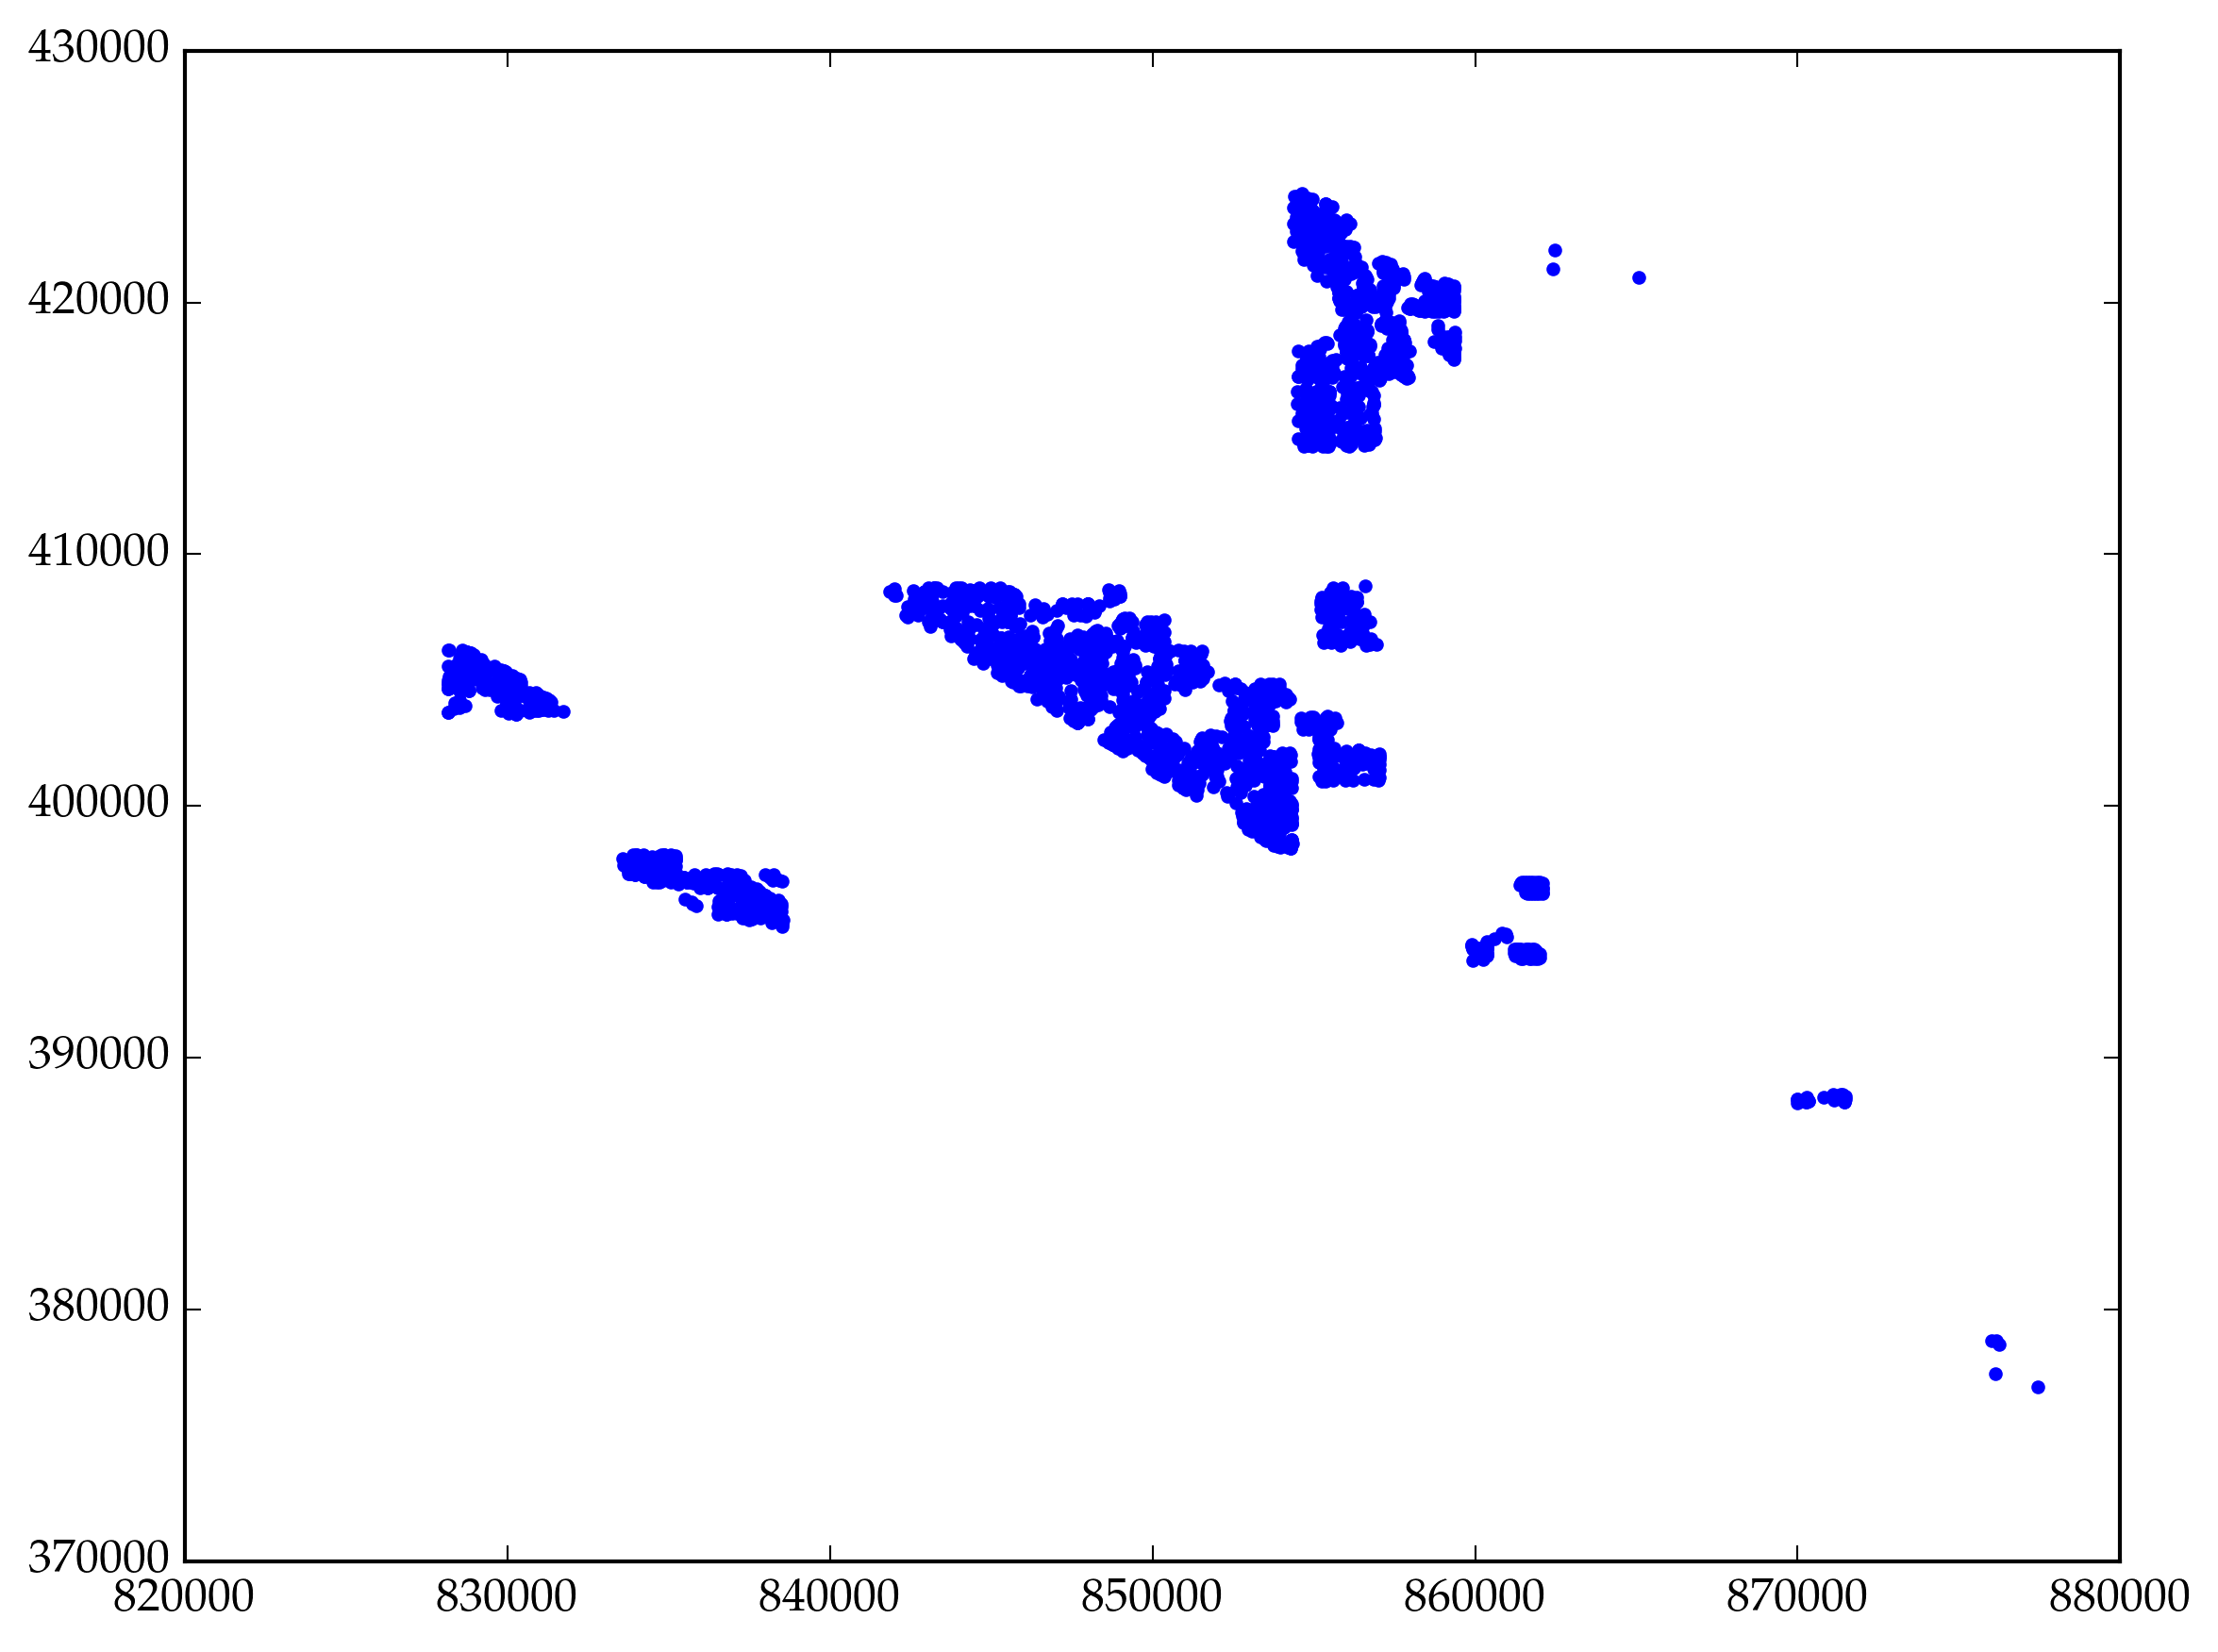

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324896f90>

In [18]:
plt.plot(X_dict["Vail Unified District"][:,1], X_dict["Vail Unified District"][:,2], ".")

In [19]:
std(X_dict["Vail Unified District"],1)

1×2 Array{Float64,2}:
 8831.95  8553.35

In [20]:
std(Y_dict["Vail Unified District"],1)

1-element Array{Float64,1}:
 0.306383

## Boundaries

In [21]:
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
;

In [22]:
sentinels_json.features[1].geometry

GeoJSON.MultiPoint(Array{Float64,1}[[7.87778e5,4.55985e5],[7.87751e5,4.56398e5],[7.8775e5,4.56813e5],[7.87746e5,457228.0],[7.87739e5,4.57643e5],[7.87735e5,4.58058e5],[7.87733e5,4.58473e5],[7.8773e5,4.58889e5],[7.87723e5,4.59304e5],[787715.0,4.59719e5],[7.8771e5,460134.0],[7.87706e5,4.60549e5],[7.877e5,4.60964e5],[7.87693e5,4.61379e5],[7.87687e5,4.61795e5],[7.87681e5,4.6221e5],[7.87678e5,462625.0],[7.87675e5,4.6304e5],[7.8767e5,4.63455e5],[787669.0,4.6387e5],[7.87644e5,4.64284e5],[7.87639e5,4.64699e5],[7.87591e5,4.65072e5],[7.87176e5,4.65072e5],[7.86991e5,4.65319e5],[7.86627e5,4.65374e5],[7.86212e5,4.65371e5],[7.85797e5,4.65373e5],[7.85624e5,4.65618e5],[7.85622e5,4.66033e5],[785629.0,4.66448e5],[7.85682e5,4.66805e5],[7.85672e5,4.6722e5],[7.85663e5,4.67635e5],[7.85562e5,4.68024e5],[7.85551e5,4.68439e5],[7.85543e5,4.68854e5],[7.8552e5,4.69251e5],[7.85105e5,469258.0],[7.85e5,4.69572e5],[7.8507e5,4.69962e5],[7.85041e5,4.7034e5],[7.84983e5,4.70746e5],[7.84978e5,4.71162e5],[7.8497e5,4.71577e5

In [23]:
sentinels_json.features[1].properties

Dict{String,Any} with 2 entries:
  "SchoolDistrict2" => "Flowing Wells Unified District"
  "SchoolDistrict1" => "Amphitheater Unified District"

In [53]:
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [25]:
sentinels

Dict{Tuple{String,String},GeoJSON.MultiPoint} with 20 entries:
  ("Vail Unified District","Sunnyside Unified District") => GeoJSON.MultiPoint(Array{Float64,1}[[8.27839e5,4.24599e5],[8.2785e5,4.24111e5],[8.27861e5,4.23624e5],[8.27872e5,4.23137e5],[8.27882e5,4.22649e5],[8.27893e5,4.22162e5],[8.27894e5,4.21675e5],[8.27888e5,4.21187e5],[8.27882e5,4.207e5],[8.27877e5,4.20213e5],[8.27868e5,4.19725e5],[8.27867e5,419238.0],[8.27872e5,4.18751e5],[8.27878e5,4.18263e5],[8.27884e5,4.17776e5],[8.27889e5,4.17289e5],[8.27895e5,4.16801e5],[8.27898e5,4.16314e5],[827901.0,4.15826e5],[8.27904e5,415339.0],[8.27907e5,4.14852e5],[8.2791e5,4.14364e5],[8.27915e5,4.13877e5],[8.2792e5,4.13389e5],[8.27926e5,412902.0],[8.27932e5,4.12415e5],[8.27938e5,4.11927e5],[8.27943e5,4.1144e5],[8.27949e5,4.10953e5],[8.27956e5,4.10465e5],[8.27964e5,4.09978e5],[8.2797e5,4.0949e5],[8.27972e5,4.09003e5],[8.27977e5,4.08516e5],[8.27982e5,4.08028e5],[827988.0,4.07541e5],[8.27992e5,4.07054e5],[8.27995e5,4.06566e5],[8.27998e5,4.06079

# Model with fixed hyperparameters
## Fit GPs for each district

Fitting the hyperparameters is a whole other difficult issue. Let's skip ahead, plug in some arbitrary values, and come back to it later.

In [26]:
GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    GP_dict[name] = fit
end

  likely near In[26]:1


In [27]:
delete!(GP_dict, "Tanque Verde Unified District");

In [30]:
for name in schdistrs
    Y = Y_dict[name]
    @printf("District %30s has %5d data points\n", name, length(Y))
end

District Flowing Wells Unified District has   155 data points
District        Tucson Unified District has 16699 data points
District  Amphitheater Unified District has   961 data points
District     Sunnyside Unified District has  1733 data points
District          Vail Unified District has  2647 data points
District  Tanque Verde Unified District has     8 data points


## 2GP posterior

In [28]:
distr1 = "Amphitheater Unified District"
distr2 = "Tucson Unified District"

"Tucson Unified District"

In [31]:
X◫ = hcat(sentinels[distr1,distr2].coordinates...)
size(X◫)

(2,100)

In [33]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [34]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

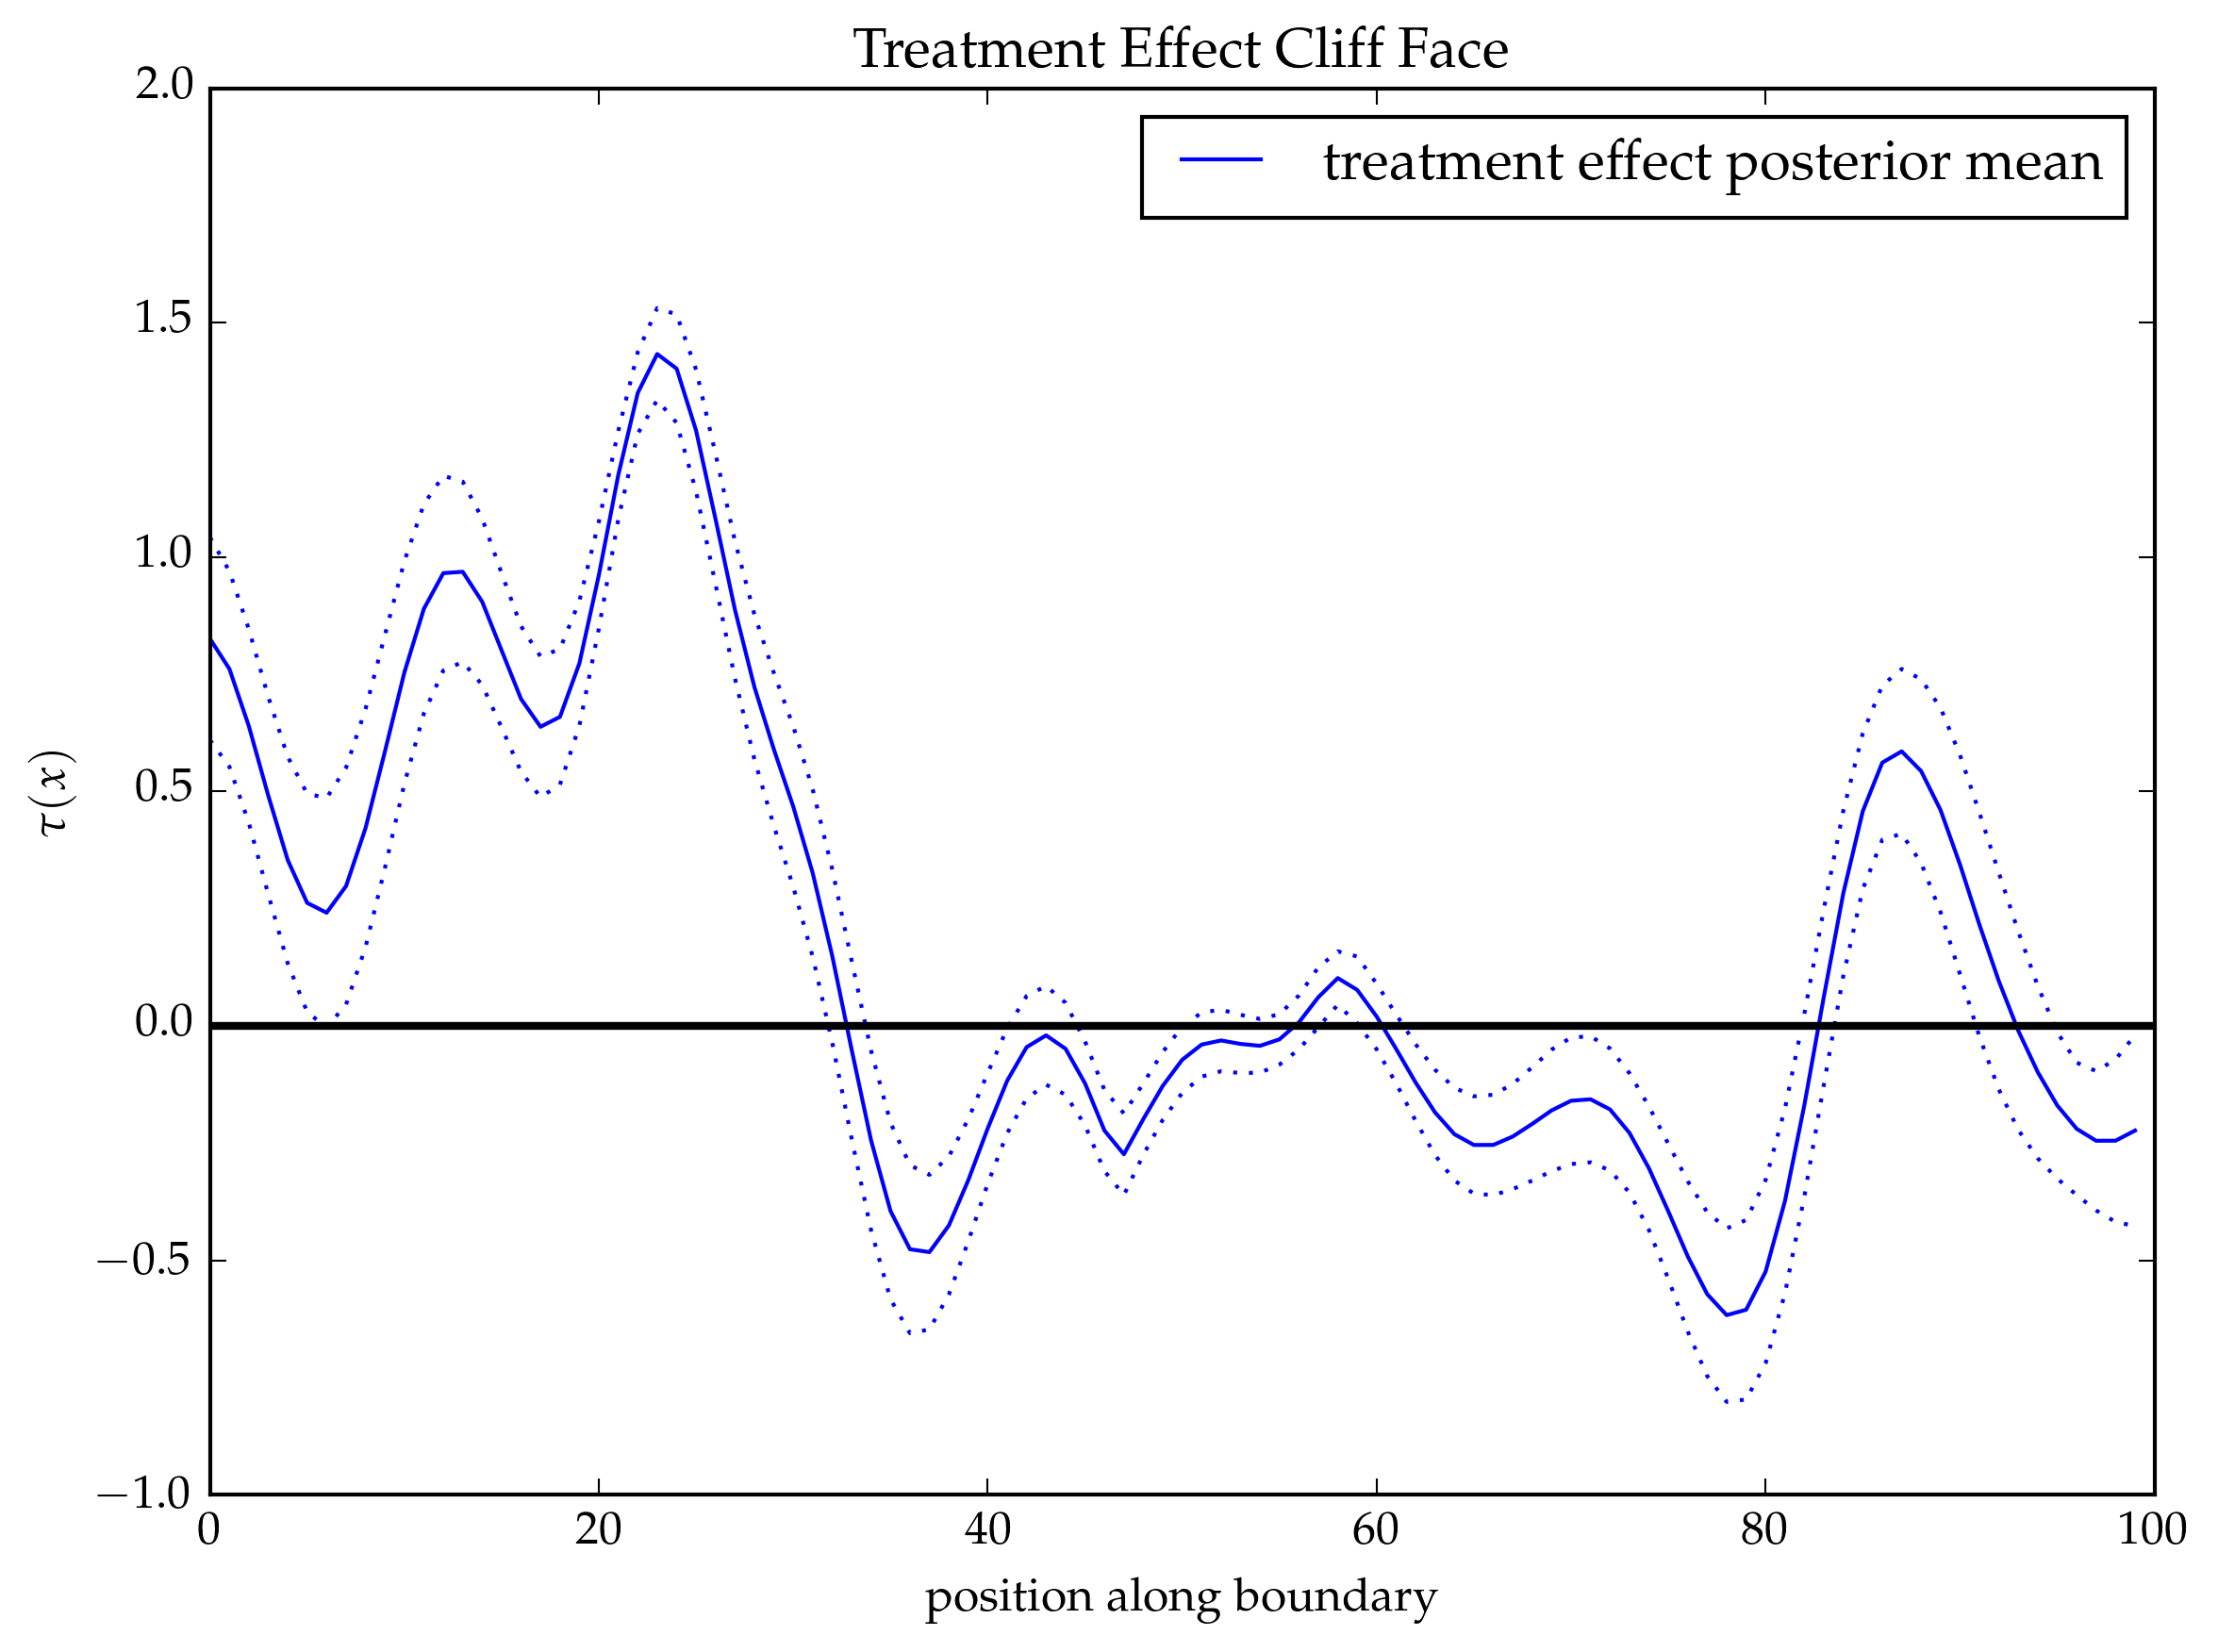

In [36]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(0.0, color="black", linewidth=2)
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

## Inverse-Variance

In [37]:
n◫ = size(X◫)[2]

100

In [38]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.1452447318908475, σ=0.02734002304962643)

# Incorporating covariates

## Linear regression ignoring spatial correlation

In [39]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);

In [40]:
Tucson_lm = lm(logSalePrice ~ SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + ROOMS + STORIES + CLASS + ROOF + GARAGE, Tucson_sales[believable,:])

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Float64}

Formula: logSalePrice ~ 1 + SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + ROOMS + STORIES + CLASS + ROOF + GARAGE

Coefficients:
                                             Estimate   Std.Error    t value Pr(>|t|)
(Intercept)                                   10.9301    0.113186    96.5678   <1e-99
SQFT                                      0.000434695  4.73121e-6    91.8783   <1e-99
SchDistr: Flowing Wells Unified District    -0.177112   0.0245984   -7.20015   <1e-12
SchDistr: Sunnyside Unified District        -0.323052   0.0116644   -27.6955   <1e-99
SchDistr: Tanque Verde Unified District     0.0876644    0.100793   0.869748   0.3844
SchDistr: Tucson Unified District          -0.0271874  0.00954664   -2.84785   0.0044
SchDistr: Vail Unified District            -0.0866852   0.0115587   -7.49959   <1e-13
COOL: None                                   0.418121    0.189

In [41]:
lm_coef_dict=Dict(zip(coefnames(Tucson_lm.mf), coef(Tucson_lm)))

Dict{String,Float64} with 47 entries:
  "COOL: Wall" => 0.0289158
  "ROOF: Metal" => 0.204511
  "ROOMS" => 7.27582e-6
  "HEAT: Forced" => 0.0284988
  "CLASS: R-2" => 0.205355
  "ROOF: Other" => -0.0697211
  "ROOF: Wood" => 0.0425679
  "GARAGE: Garage" => 0.0890214
  "ROOF: Asphalt" => -0.109303
  "HEAT: Floor Furnance" => 0.156645
  "WALLS: Adobe" => 0.106986
  "GARAGE: None" => -0.0164695
  "QUALITY: Minimum" => -0.47668
  "WALLS: Stone" => 0.171997
  "SchDistr: Sunnyside Unified District" => -0.323052
  "ROOF: Built Up" => -0.105913
  "HEAT: Gravity" => 0.250918
  "HEAT: Other" => -0.0063304
  "CLASS: R-4" => 0.840132
  "COOL: Refrigeration" => 0.107278
  "ROOF: Tile" => -0.0672983
  "SchDistr: Vail Unified District" => -0.0866852
  "QUALITY: Good" => -0.172276
  "SchDistr: Tucson Unified District" => -0.0271874
  "WALLS: Brick" => 0.14904
  "STORIES" => -0.0809111
  "(Intercept)" => 10.9301
  "CLASS: R-5" => 1.01747
  "CLASS: R-3" => 0.518367
  "WALLS: Framed Block" => 0.0556392
  "

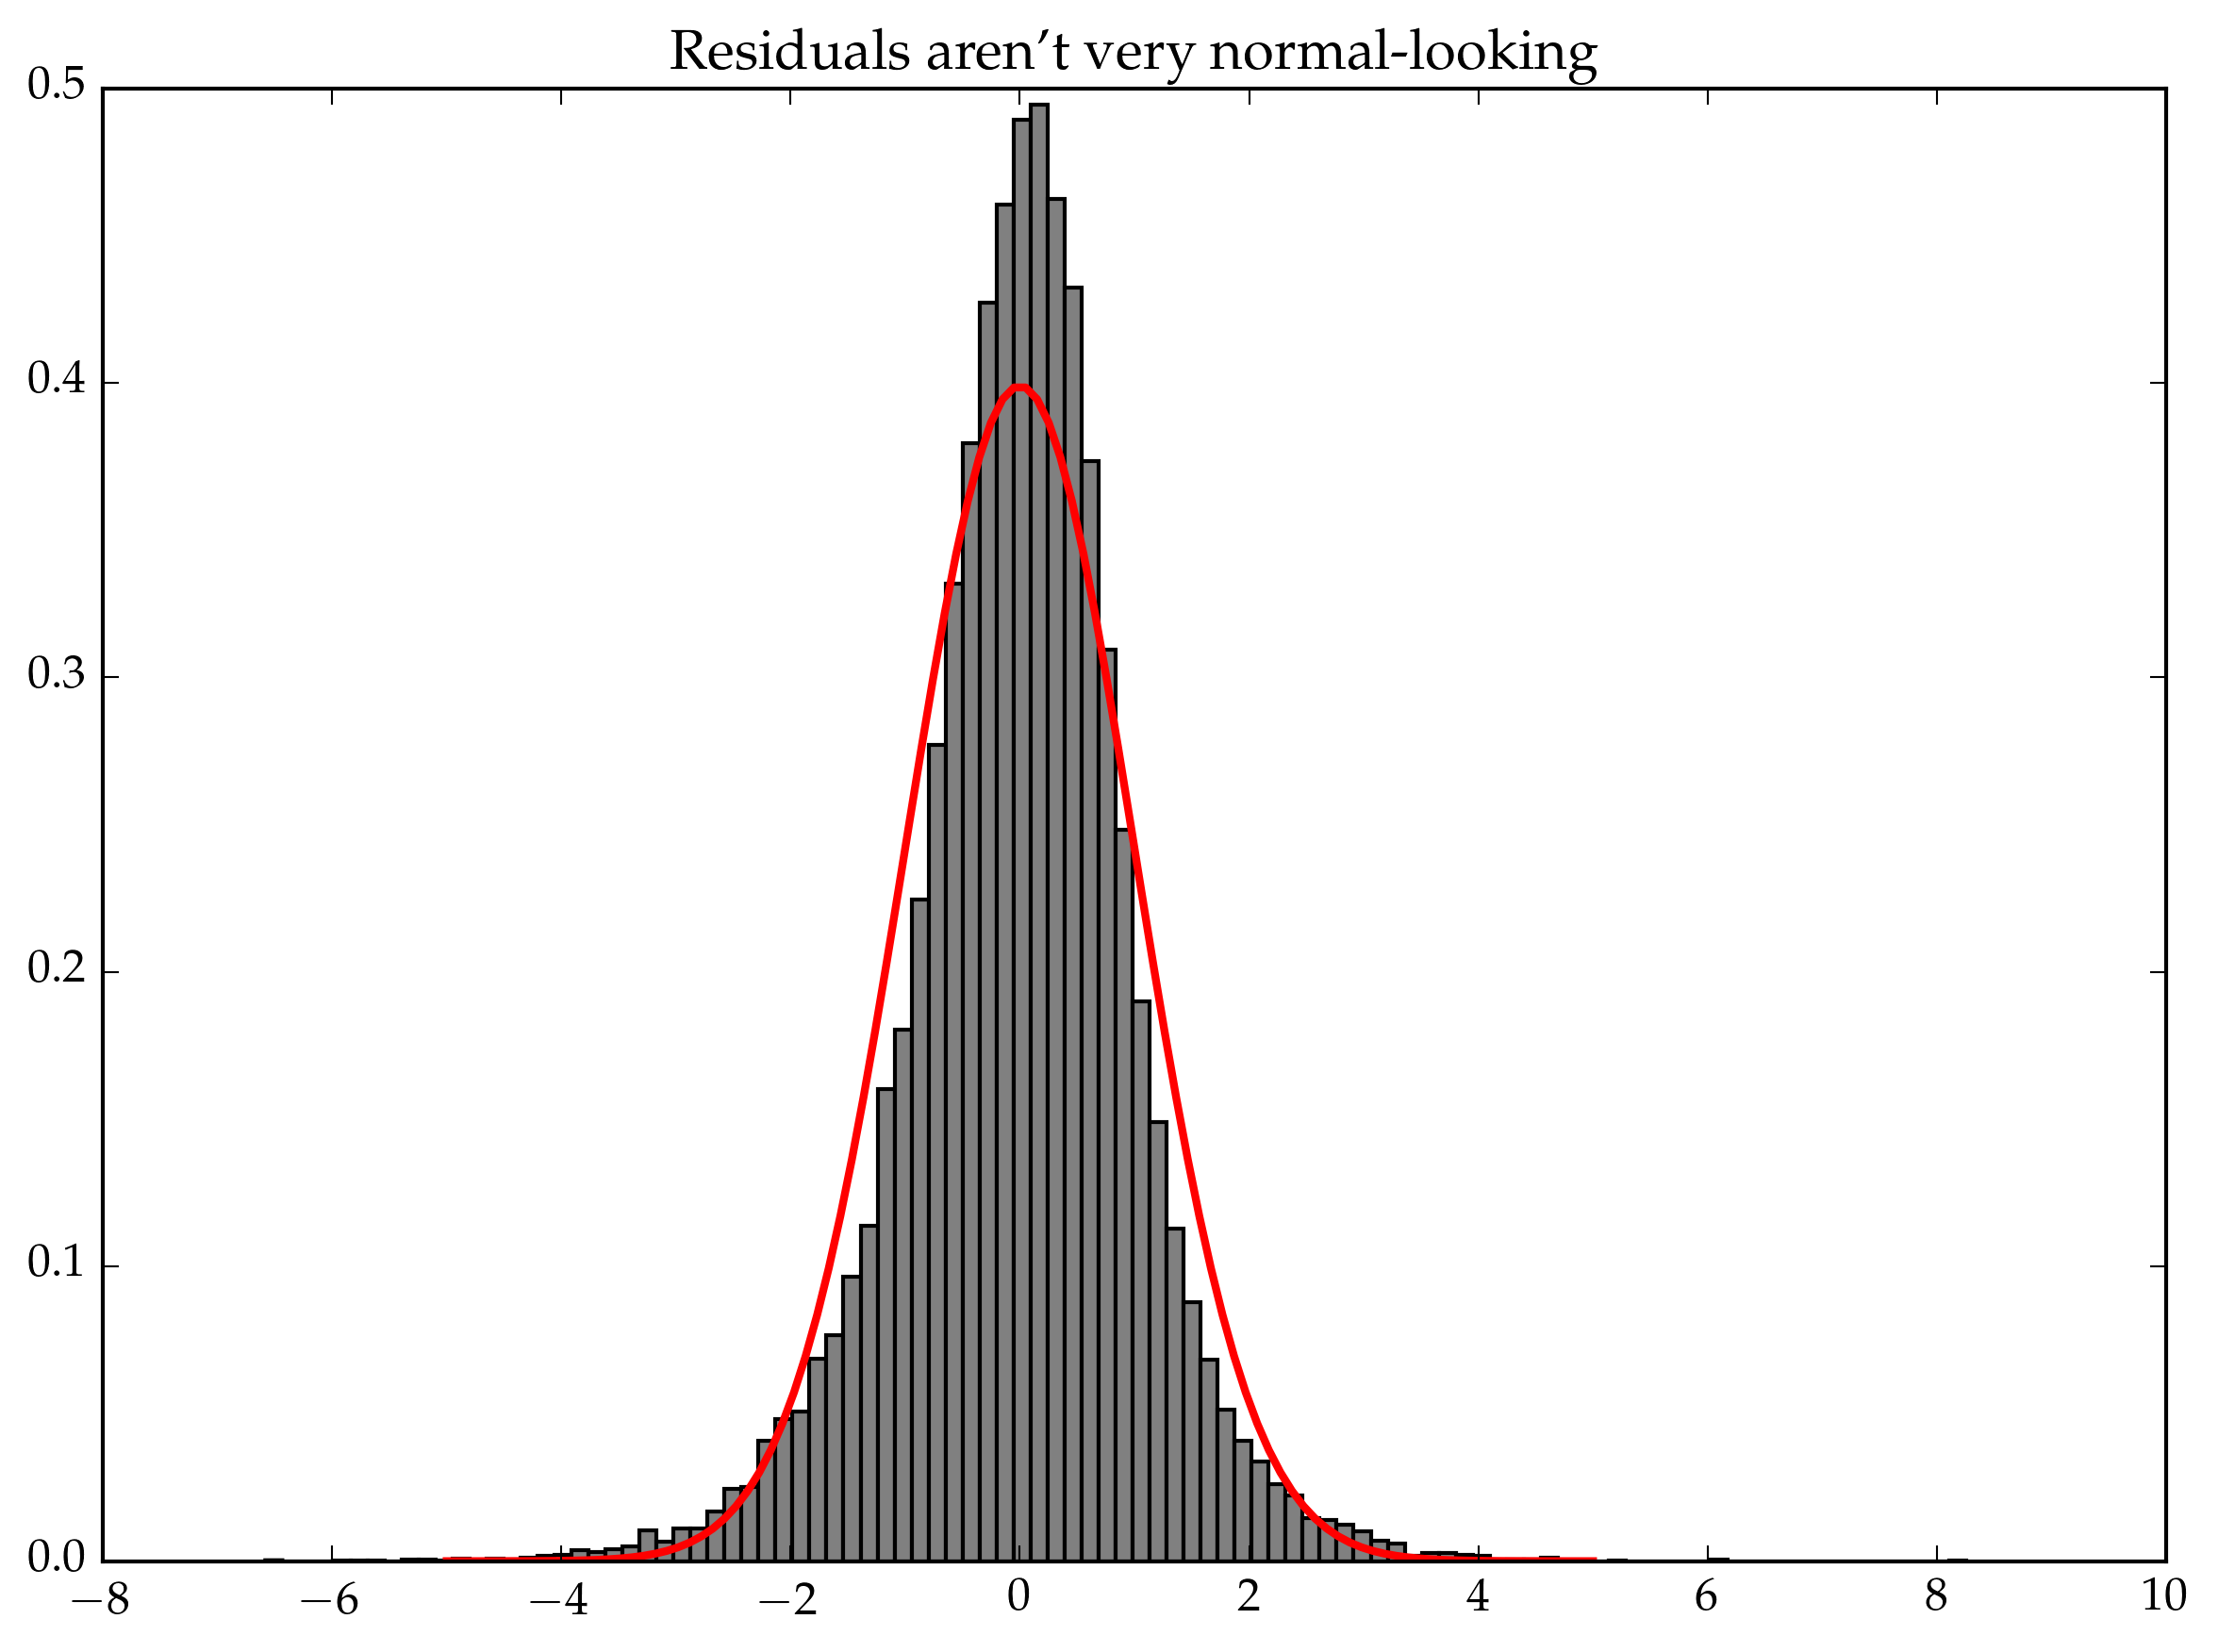

In [42]:
lm_residuals=residuals(Tucson_lm)
plt.plt[:hist](lm_residuals/std(lm_residuals),bins=100, normed=true, color="grey")
plt.plot(linspace(-5,5,100), pdf(Normal(), linspace(-5,5,100)), color="red", linewidth=2)
plt.title("Residuals aren't very normal-looking")
;

## Ridge regression

In [48]:
contrasts_dict = Dict()
for (term,col) in eachcol(Tucson_sales)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + ROOMS + STORIES + CLASS + ROOF + GARAGE, 
    Tucson_sales[believable,:], 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)

ridge_Y = convert(Vector{Float64}, mf.df[:logSalePrice])
ridge_coef=mvst.ridge(mm.m, ridge_Y, 100.0, bias=false)

55-element Array{Float64,1}:
  3.58508    
  0.000630194
  0.843091   
  0.442655   
  0.558913   
  0.076533   
  0.89038    
  0.773512   
  1.33889    
  0.0775718  
  1.4173     
  0.751328   
  0.121109   
  0.49086    
  1.04103    
  0.140707   
  0.155494   
  0.689856   
  0.0652146  
  0.0124586  
  0.868356   
  0.451521   
  0.650189   
  0.509501   
  0.586362   
  0.163639   
  0.495349   
  0.215409   
  0.429397   
  0.0837168  
  0.360623   
  1.13671    
  1.18433    
  0.903419   
 -0.000996101
 -0.0239556  
  0.180006   
  0.716332   
  0.923299   
  1.09809    
  0.682034   
 -0.0146753  
  0.401672   
  0.467854   
  0.489219   
  0.444617   
  0.21055    
  0.620925   
  0.0176078  
  0.490647   
  0.441992   
  0.919965   
  1.00222    
  0.758135   
  0.904768   

In [33]:
ridge_coef_dict=Dict(zip(coefnames(mf), ridge_coef))

Dict{String,Float64} with 47 entries:
  "COOL: Wall" => 0.268997
  "ROOF: Metal" => 0.47445
  "ROOMS" => -0.00139532
  "HEAT: Forced" => 1.52598
  "CLASS: R-2" => 1.11802
  "ROOF: Other" => 0.242444
  "ROOF: Wood" => 0.510141
  "GARAGE: Garage" => 0.13107
  "ROOF: Asphalt" => 0.572685
  "HEAT: Floor Furnance" => 0.695127
  "WALLS: Adobe" => 0.218747
  "GARAGE: None" => 0.0757852
  "QUALITY: Minimum" => 1.30813
  "WALLS: Stone" => 0.0476327
  "SchDistr: Sunnyside Unified District" => 0.100319
  "ROOF: Built Up" => 0.599593
  "HEAT: Gravity" => 0.192071
  "HEAT: Other" => 0.852356
  "CLASS: R-4" => 1.46594
  "COOL: Refrigeration" => 0.117078
  "ROOF: Tile" => 0.569932
  "SchDistr: Vail Unified District" => 0.287513
  "QUALITY: Good" => 1.59003
  "SchDistr: Tucson Unified District" => 0.38712
  "WALLS: Brick" => 0.291029
  "STORIES" => 0.00170638
  "(Intercept)" => 5.08144
  "CLASS: R-5" => 0.867748
  "CLASS: R-3" => 1.34281
  "WALLS: Framed Block" => 0.0659249
  "ROOF: Slate" => 0.020086

In [49]:
ridge_coef_dict=Dict(zip(coefnames(mf), ridge_coef))

Dict{String,Float64} with 55 entries:
  "COOL: Wall" => 0.751328
  "COOL: Evaporative" => 1.33889
  "ROOF: Metal" => 0.444617
  "ROOMS" => -0.000996101
  "HEAT: Forced" => 1.04103
  "CLASS: R-2" => 0.716332
  "CLASS: R-1" => 0.180006
  "ROOF: Other" => 0.21055
  "ROOF: Wood" => 0.441992
  "GARAGE: Garage" => 1.00222
  "ROOF: Asphalt" => 0.467854
  "HEAT: Floor Furnance" => 0.49086
  "WALLS: Adobe" => 0.509501
  "HEAT: Electric Panel" => 0.121109
  "WALLS: 8 inch Painted" => 0.451521
  "GARAGE: None" => 0.904768
  "QUALITY: Minimum" => 0.903419
  "WALLS: Stone" => 0.0837168
  "ROOF: Asbestos" => 0.401672
  "SchDistr: Sunnyside Unified District" => 0.558913
  "ROOF: Built Up" => 0.489219
  "HEAT: Gravity" => 0.140707
  "HEAT: Other" => 0.689856
  "CLASS: R-4" => 1.09809
  "COOL: Refrigeration" => 1.4173
  "ROOF: Tile" => 0.490647
  "SchDistr: Vail Unified District" => 0.773512
  "QUALITY: Good" => 1.18433
  "SchDistr: Tucson Unified District" => 0.89038
  "WALLS: Brick" => 0.586362
  "ST

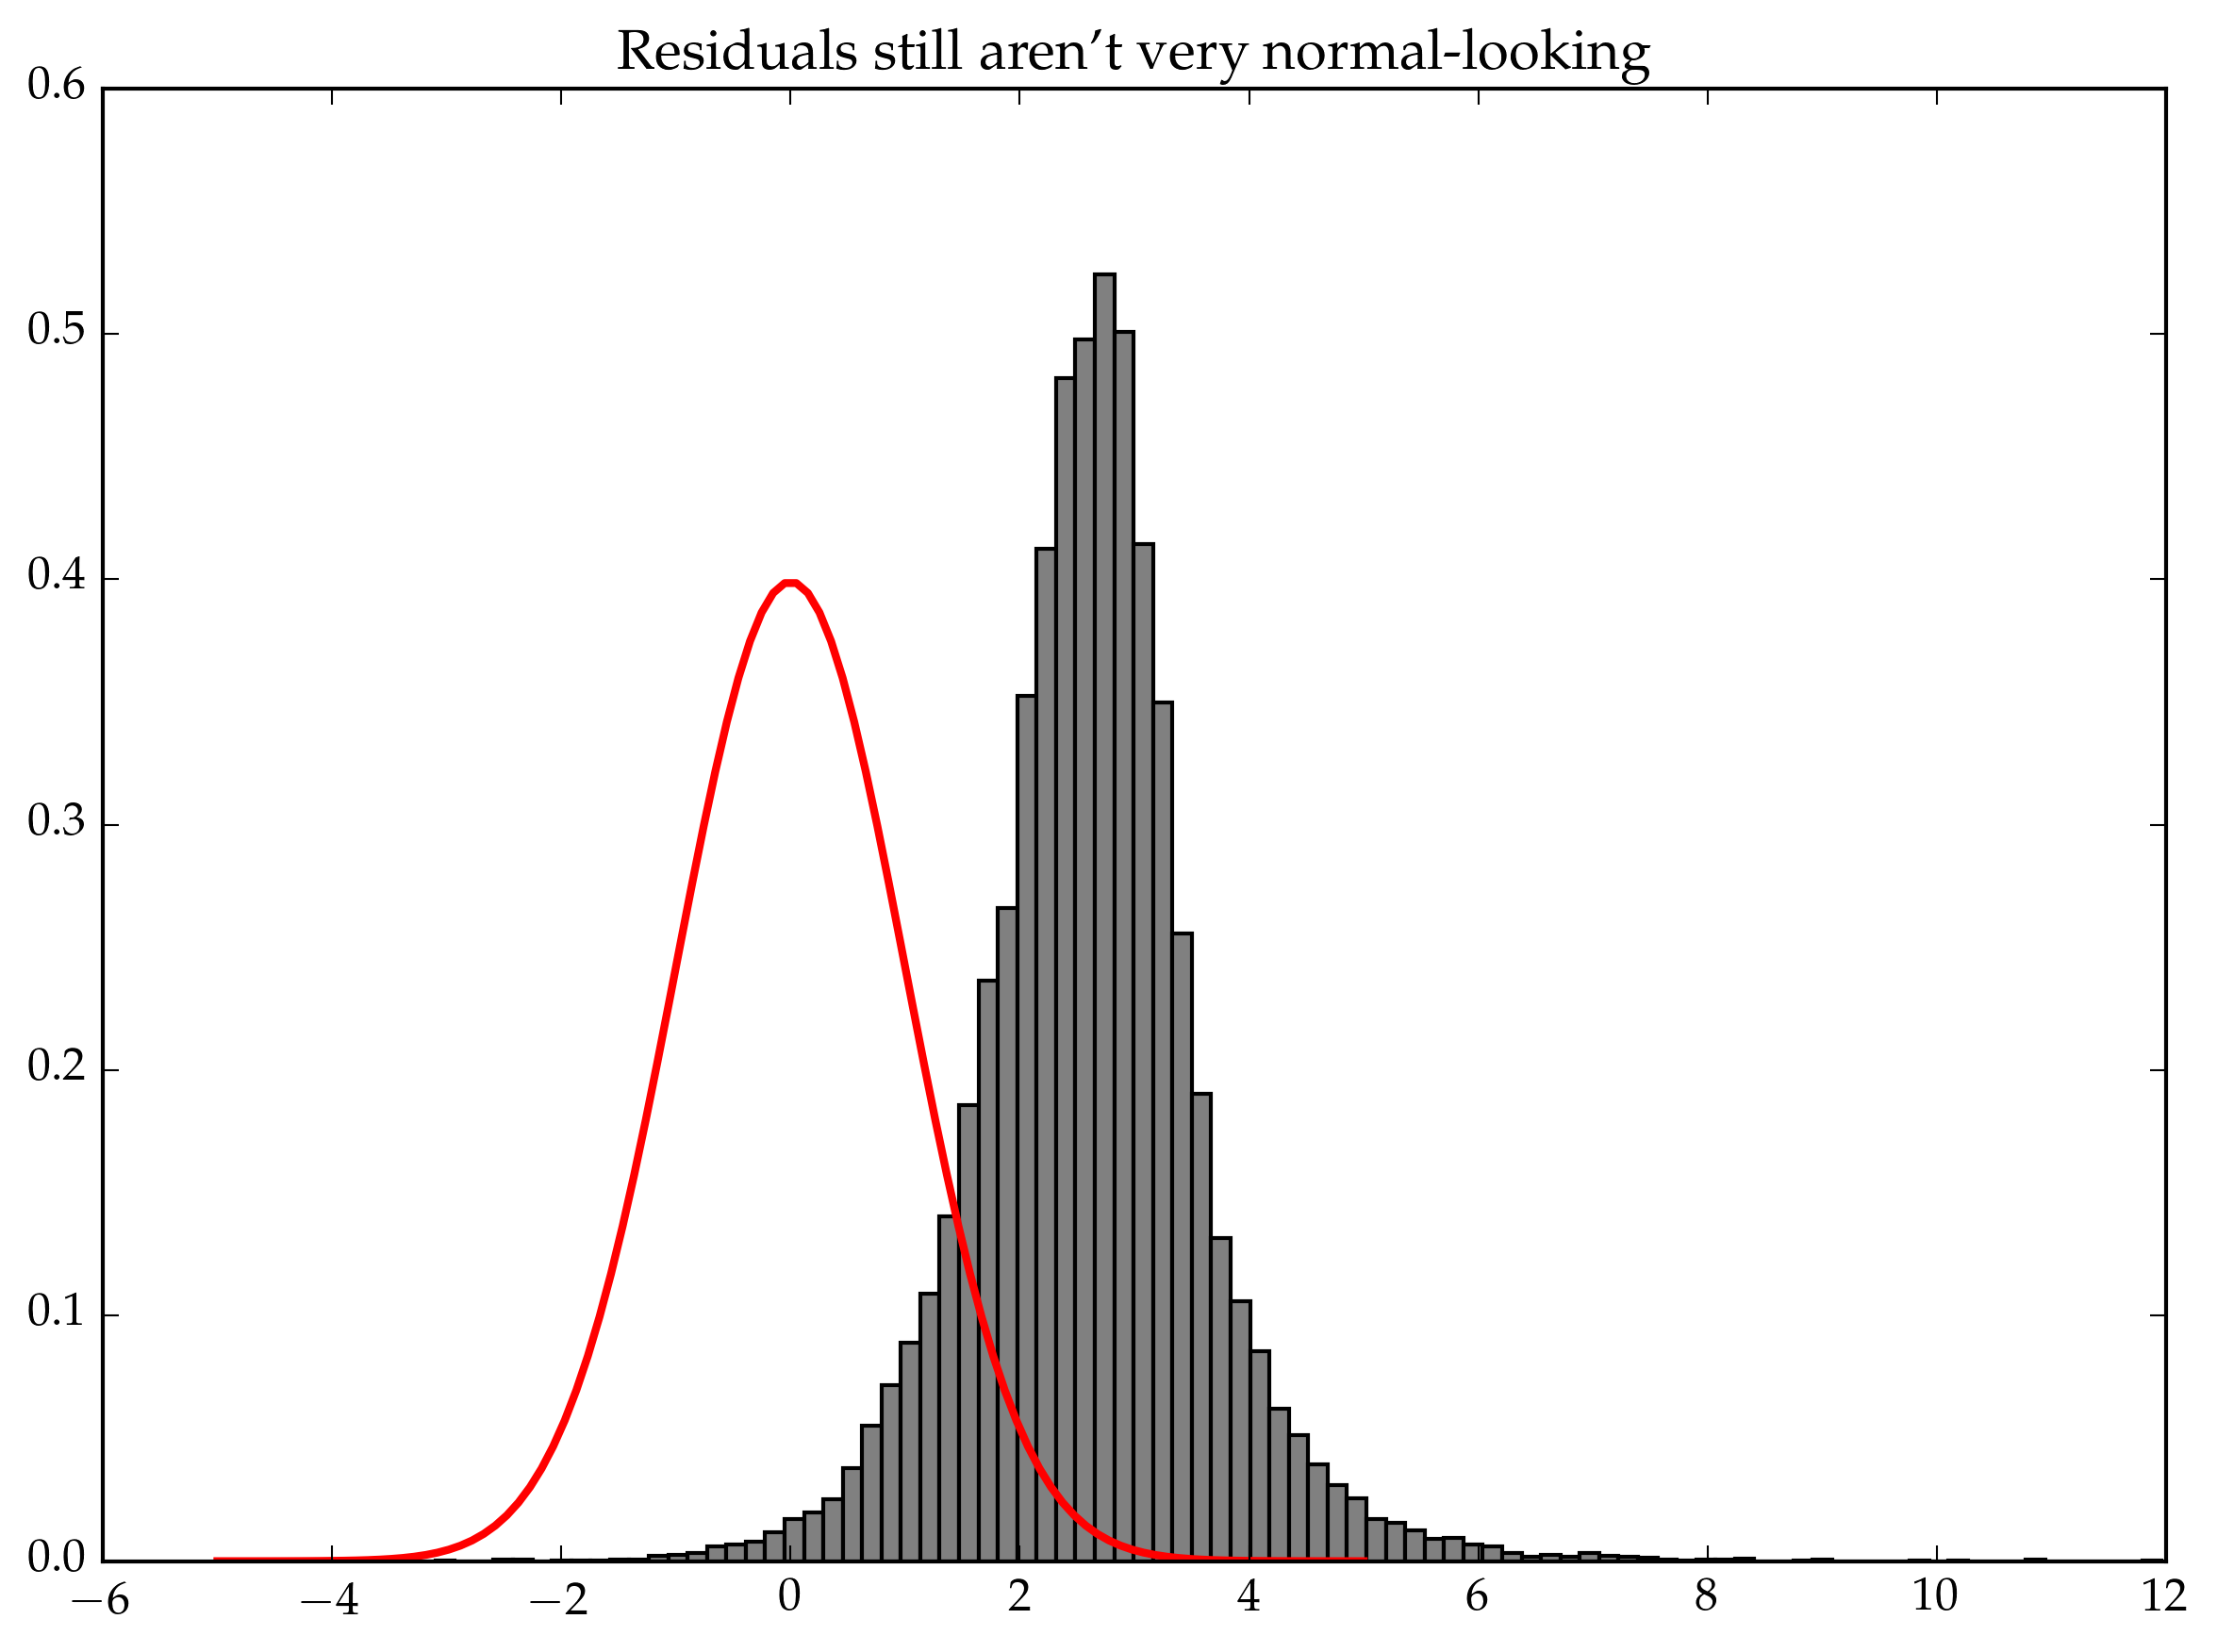

In [50]:
βhat_noschdistr = copy(ridge_coef)
βhat_noschdistr[[contains(x,"SchDistr: ") for x in coefnames(mf)]] = 0.0

ridge_pred = mm.m * βhat_noschdistr
ridge_resid = ridge_Y  .- ridge_pred
plt.plt[:hist](ridge_resid/std(ridge_resid),bins=100, normed=true, color="grey")
plt.plot(linspace(-5,5,100), pdf(Normal(), linspace(-5,5,100)), color="red", linewidth=2)
plt.title("Residuals still aren't very normal-looking")
;

## Fitting GPs to residuals

In [51]:
resid_dict=Dict{String, Vector{Float64}}()
recent_lm_resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    schdistr_coef = get(lm_coef_dict, "SchDistr: "name, 0.0)
    resid_dict[name] = lm_residuals[Tucson_sales[believable,:][:SchDistr] .== name] + schdistr_coef
    recent_lm_resid_dict[name] = lm_residuals[recent_in_believable & (Tucson_sales[believable,:][:SchDistr] .== name)] + schdistr_coef
end
ridge_resid_dict=Dict{String, Vector{Float64}}()
recent_ridge_resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    ridge_resid_dict[name] = ridge_resid[Tucson_sales[believable,:][:SchDistr] .== name]
    recent_ridge_resid_dict[name] = ridge_resid[recent_in_believable & (Tucson_sales[believable,:][:SchDistr] .== name)]
end

  likely near In[51]:1
  likely near In[51]:2
  likely near In[51]:8
  likely near In[51]:9


In [52]:
resid_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    resid_GP_dict[name] = fit
end

  likely near In[52]:1


In [54]:
resid_pred_1 = GaussianProcesses.predict(resid_GP_dict[distr1], X◫; full_cov=true)
resid_pred_2 = GaussianProcesses.predict(resid_GP_dict[distr2], X◫; full_cov=true)
;

In [55]:
resid_μposterior = resid_pred_1[1].-resid_pred_2[1]
resid_Σposterior = resid_pred_1[2]+resid_pred_2[2]
;

In [56]:
ridge_GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = ridge_resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    ridge_GP_dict[name] = fit
end

In [57]:
ridge_pred_1 = GaussianProcesses.predict(ridge_GP_dict[distr1], X◫; full_cov=true)
ridge_pred_2 = GaussianProcesses.predict(ridge_GP_dict[distr2], X◫; full_cov=true)
;

In [58]:
ridge_μposterior = ridge_pred_1[1].-ridge_pred_2[1]
ridge_Σposterior = ridge_pred_1[2]+ridge_pred_2[2]
;

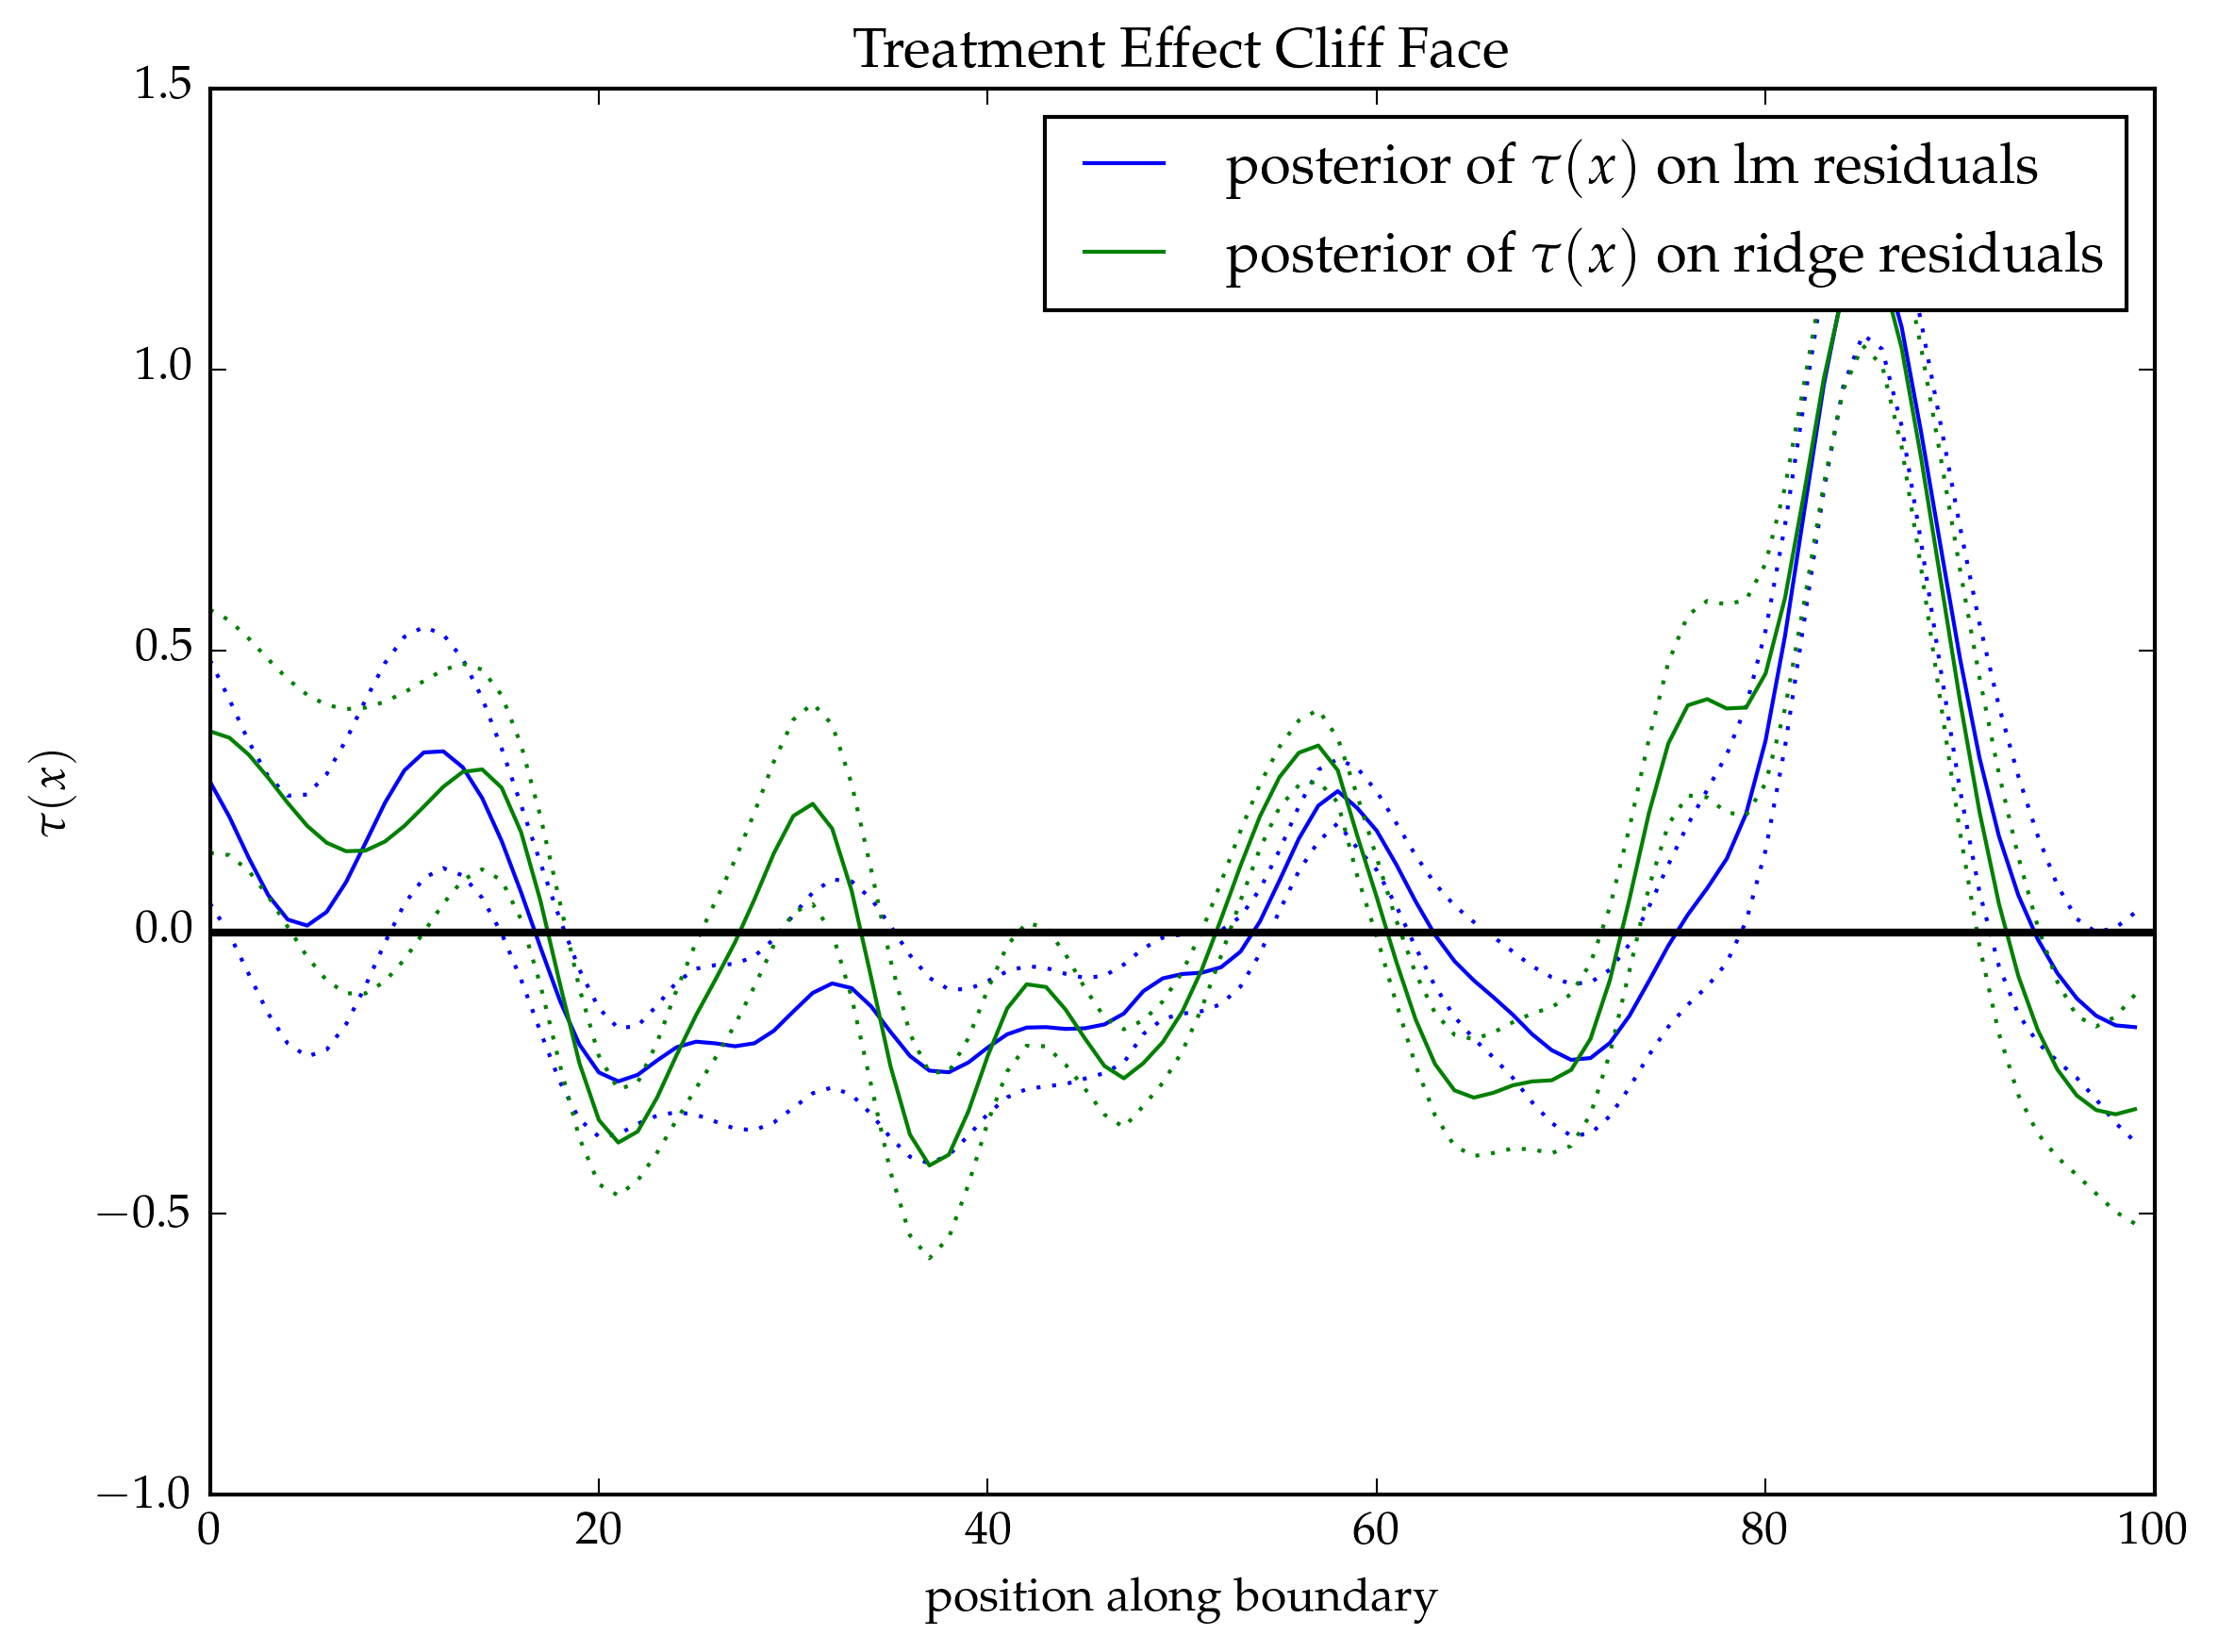

In [59]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on lm residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(ridge_μposterior, color="green", label=L"posterior of $\tau(x)$ on ridge residuals")
plt.plot(ridge_μposterior.+√diag(ridge_Σposterior), color="green", linestyle=":")
plt.plot(ridge_μposterior.-√diag(ridge_Σposterior), color="green", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

The treatment effect derived from the linear regression and ridge regression residuals are broadly in agreement. Troublingly, the sign of the treatment effect is not consistent along the boundary, which is difficult to explain. Our story is that one school district performs better than the other, and so house prices should increase or decrease discontinuously at the boundary. It doesn't make much sense for prices to increase on one side of the boundary, and decrease on the other.

# Hyperparameters

Now the difficult part. We need to fit the GP hyperparameters to the data.

In [60]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP,1}

In [64]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gps::MultiGP`: Vector of Gaussian Processes to fit with the same parameters
* `noise::Bool`: Noise hyperparameters should be optimized
* `mean::Bool`: Mean function hyperparameters should be optimized
* `kern::Bool`: Kernel function hyperparameters should be optimized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function GaussianProcesses.optimize!(mgp::MultiGP; noise::Bool=true, mean::Bool=true, kern::Bool=true, method=ConjugateGradient(), kwargs...)
    Kgrads = Matrix{Float64}[]
    for gp in mgp
        push!(Kgrads, Array(Float64, gp.nobsv, gp.nobsv))
    end
    function mll(hyp::Vector{Float64})
        mLL = 0.0
        println("mll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll!!(gp)
                mLL += gp.mLL
            end
        catch err
            if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end  
        println("-mLL: ", -mLL)
        return -mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        println("dmll setting parameters: ", hyp)
        for (igp,gp) in enumerate(mgp)
            Kgrad = Kgrads[igp]
            GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
            GaussianProcesses.update_mll_and_dmll!(gp, Kgrad; noise=noise, mean=mean, kern=kern)
            grad[:] -= gp.dmLL
        end
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        mLL = 0.0
        println("mll_and_dmll setting parameters: ", hyp)
        try
            for (igp,gp) in enumerate(mgp)
                Kgrad = Kgrads[igp]
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll_and_dmll!(gp, Kgrad; noise=noise, mean=mean, kern=kern)
                mLL += gp.mLL
                grad[:] -= gp.dmLL
            end
        catch err
            if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end  
        println("-mLL: ", -mLL)
        return -mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = GaussianProcesses.get_params(mgp[1];  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    return results
end

GaussianProcesses.optimize!

In [62]:
recent_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_GP_dict[name] = fit
end
recent_multiGP = collect(values(recent_GP_dict))
init_params = GaussianProcesses.get_params(recent_multiGP[1])

  likely near In[62]:1


4-element Array{Float64,1}:
 -2.30259
 11.7666 
  6.90776
 -1.60944

In [65]:
@time hyp_fit=optimize!(recent_multiGP, 
    noise=true, mean=true, kern=true, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10);

Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.30259,11.7666,6.90776,-1.60944]
-mLL: 5007.796277026529
     0     5.007796e+03     1.215710e+04
mll setting parameters: [2429.12,447.743,-655.515,776.398]
-mLL: NaN
mll setting parameters: [240.839,55.3643,-59.3345,76.1913]
Base.LinAlg.PosDefException(1501)
mll setting parameters: [22.0116,16.1264,0.28353,6.17064]
-mLL: 122655.56942100634
New linesearch
mll_and_dmll setting parameters: [22.0116,16.1264,0.28353,6.17064]
-mLL: 122655.56942100634
bracketing: ia = 1, ib = 2, c = 0.0020000000000000005, phic = 122655.56942100634, dphic = 6.5028347434661396e7
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.0020000000000000005, phi(a) = 5007.796277026529, phi(b) = 122655.56942100634
secant2: a = 0.0, b = 0.0020000000000000005, c = 0.0014662761707514348
mll_and_dmll setting parameters: [15.5231,14.9629,2.05128,4.09443]
-mLL: 87948.39081878882
update: ia = 1, a = 0.0, ib = 2, b = 0.0020000000000000005, c = 0.00146627617075

In [67]:
hyp_fit

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-2.3025850929940455,11.766598687771586, ...]
 * Minimizer: [-1.5645604592589313,11.945644543869337, ...]
 * Minimum: 6.264973e+02
 * Iterations: 10
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 40
 * Gradient Calls: 28

In [84]:
gp=recent_GP_dict["Amphitheater Unified District"];

Great! The optimization took 13.5 minutes [update: now 3.5 minutes with some improvements I made to the GaussianProcesses library], which is perhaps reasonable. Now let's reset the GPs and optimize again with the LBFGS method instead of ConjugateGradient, to see if we get the same result, and which is faster.

In [68]:
for gp in recent_multiGP
    GaussianProcesses.set_params!(gp, init_params)
end

In [69]:
@time begin
    hyp_fit2=optimize!(recent_multiGP, 
        noise=true, mean=true, kern=true, 
        method=LBFGS(), 
        show_trace=true, iterations=10)
    print("\n")
end

Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.30259,11.7666,6.90776,-1.60944]
-mLL: 5007.796277026529
     0     5.007796e+03     1.215710e+04
New linesearch
mll_and_dmll setting parameters: [12154.8,2191.65,-3305.2,3888.43]
-mLL: NaN
mll_and_dmll setting parameters: [1213.41,229.755,-324.303,387.394]
-mLL: NaN
mll_and_dmll setting parameters: [119.268,33.5654,-26.2134,37.2909]
Base.LinAlg.PosDefException(1501)
mll_and_dmll setting parameters: [9.85452,13.9465,3.59564,2.2806]
-mLL: 57627.222722185244
bracketing: ia = 1, ib = 2, c = 0.0010000000000000002, phic = 57627.222722185244, dphic = 6.502833509728075e7
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.0010000000000000002, phi(a) = 5007.796277026529, phi(b) = 57627.222722185244
secant2: a = 0.0, b = 0.0010000000000000002, c = 0.0007331381224944079
mll_and_dmll setting parameters: [6.61025,13.3648,4.47952,1.2425]
-mLL: 40273.703603834576
update: ia = 1, a = 0.0, ib = 2, b = 0.0010000000000000002, c = 0.0007

In [70]:
hyp_fit2

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-2.3025850929940455,11.766598687771586, ...]
 * Minimizer: [-1.5634357281679145,11.948545900063513, ...]
 * Minimum: 6.265584e+02
 * Iterations: 10
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 55
 * Gradient Calls: 55

We reach the same parameter values, but it took a lot longer! We should stick with conjugate gradient descent.

In [71]:
hyp_fit.minimum

4-element Array{Float64,1}:
 -1.56456
 11.9456 
  7.01173
 -1.00413

In [78]:
gp=next(values(recent_GP_dict),1)[1]
k=gp.k
@printf("σ_f: %.2f\n", √k.σ2)
@printf("σ_y: %.2f\n", exp(gp.logNoise))
@printf("ℓ: %.1f\n", √(k.ℓ2))

σ_f: 0.37
σ_y: 0.21
ℓ: 1117.5


In [79]:
pred_1 = GaussianProcesses.predict(recent_GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(recent_GP_dict[distr2], X◫; full_cov=true)
;

In [80]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

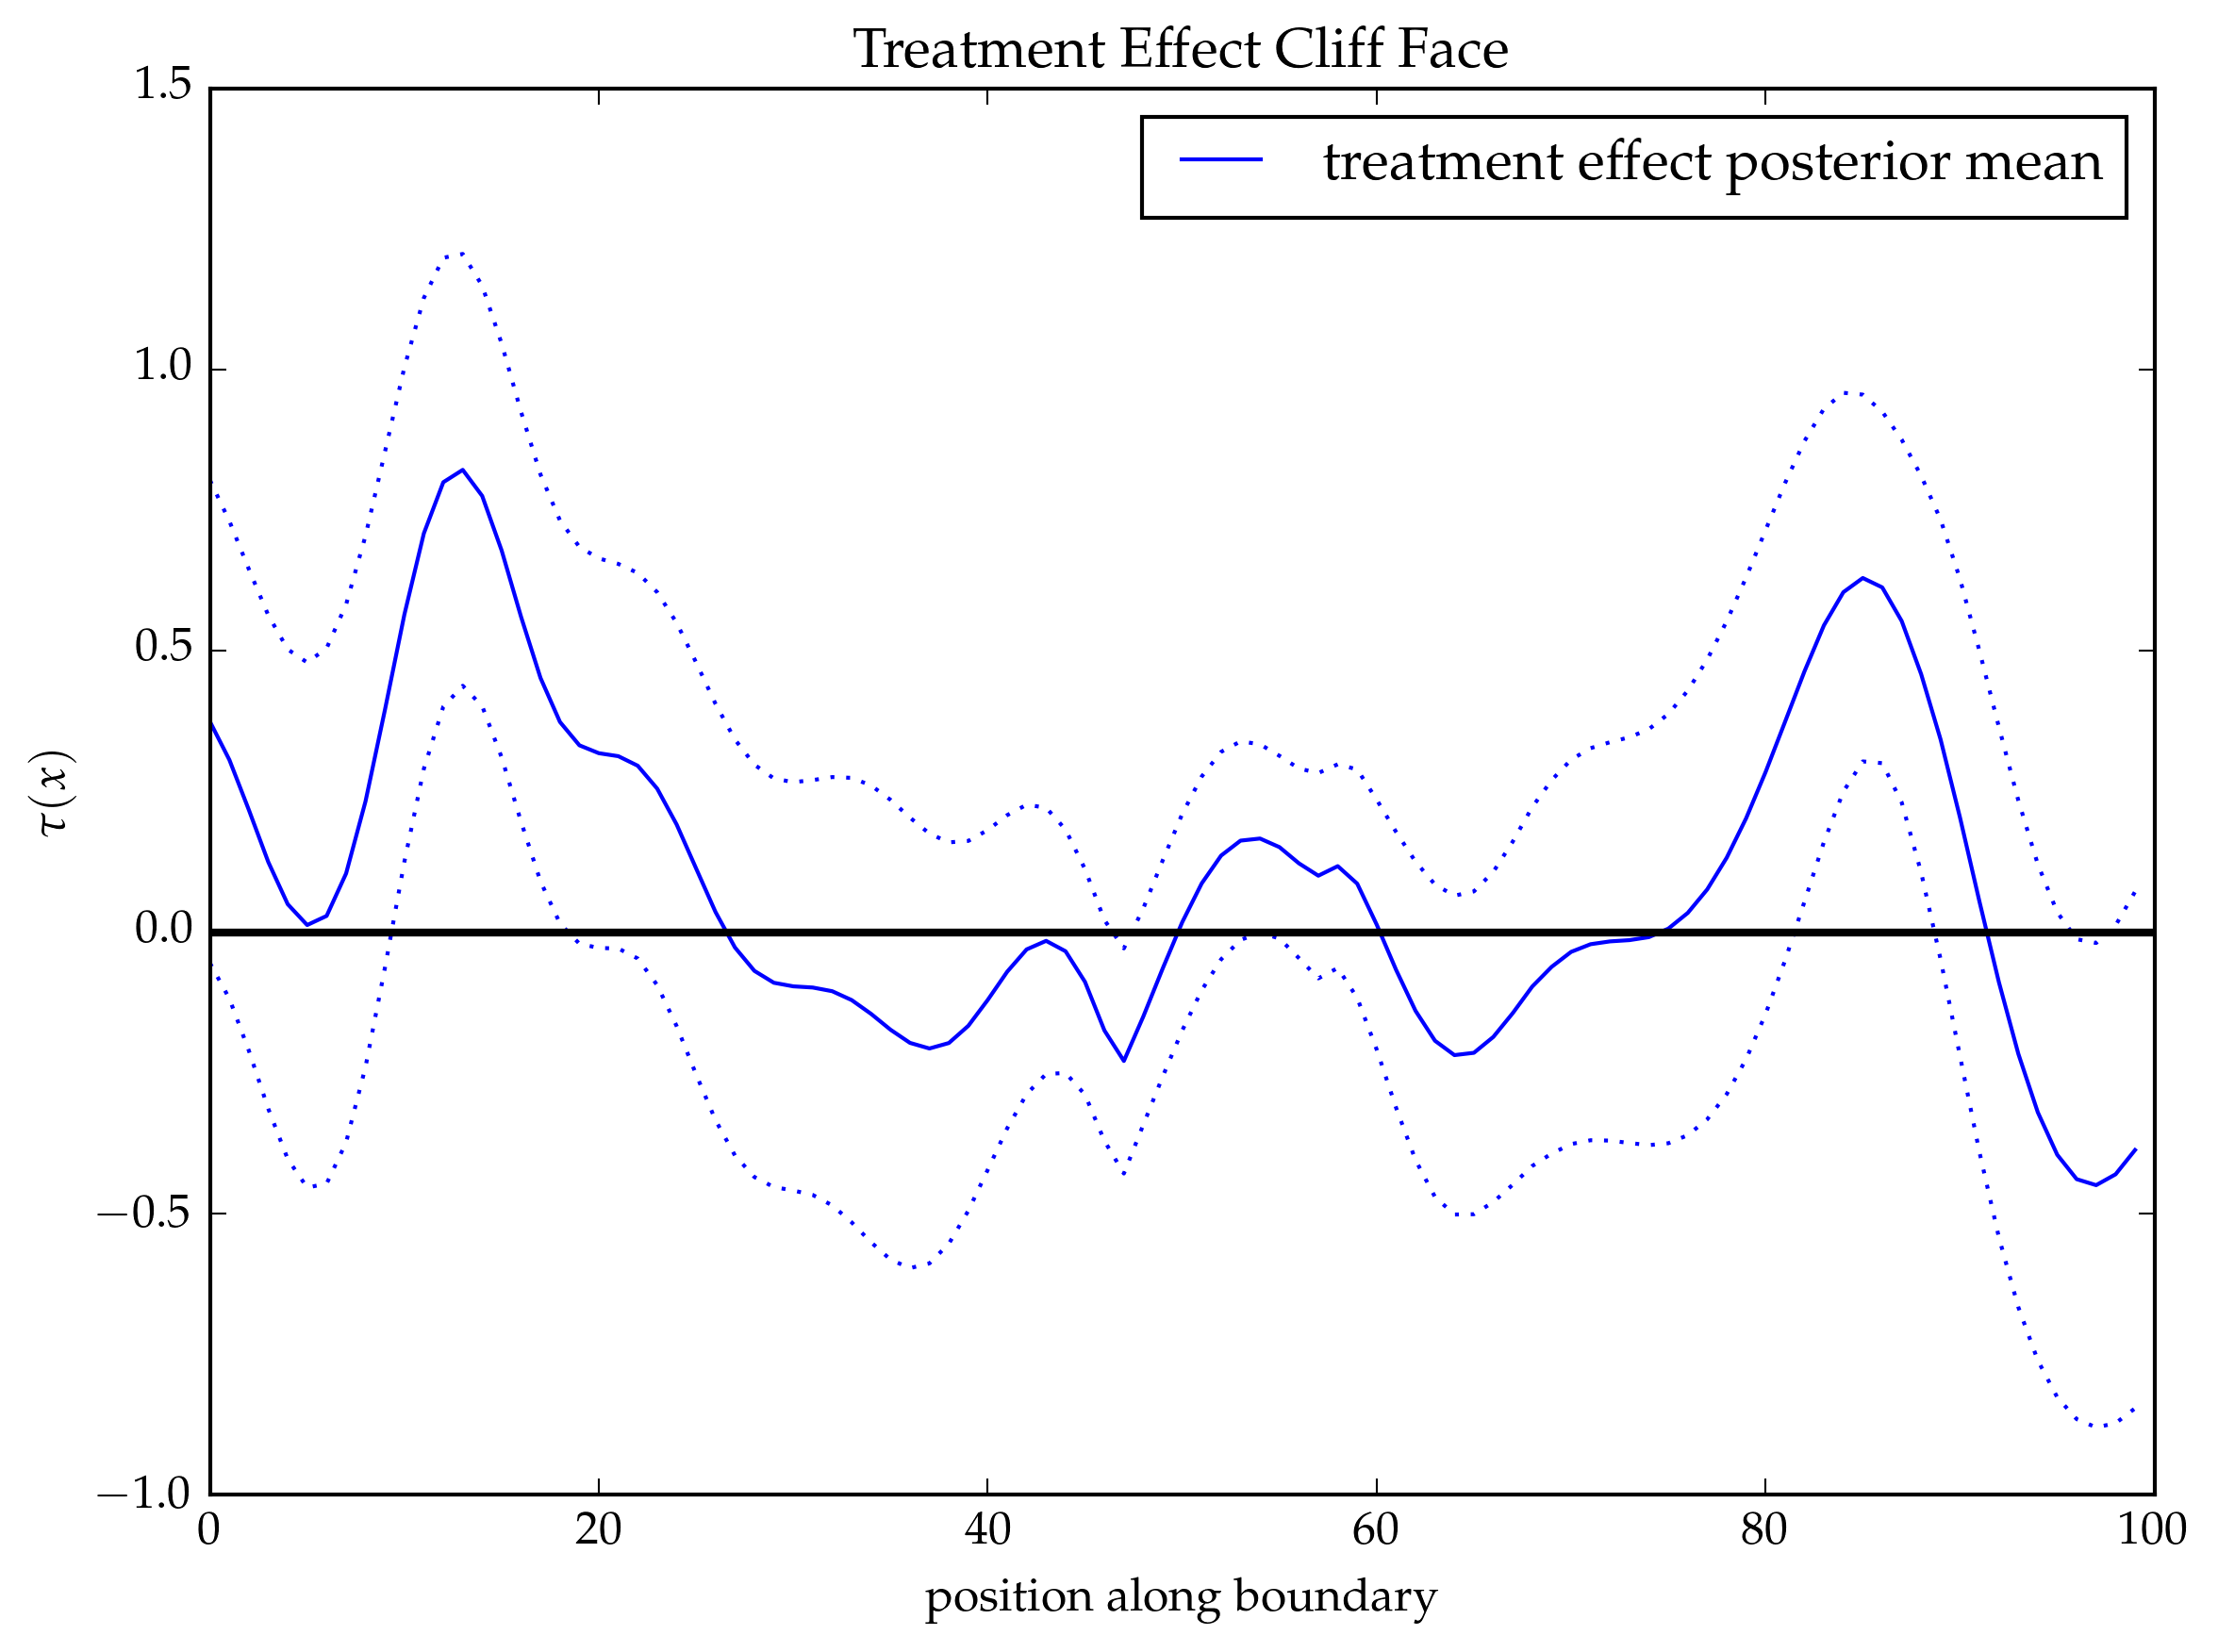

In [81]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [82]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.05208072854960829, σ=0.07995647747628197)

This new value of the hyperparameters changes the inverse-variance-weighted mean somewhat, and its posterior standard deviation by a lot. This shows that the choice of hyperparameters is crucial for inference, and needs to be thought about very carefully. From an interpretation point of view, it's troubling that the posterior treatment effect goes from being positive to negative as we move along the school district boundary.

**NOTE** Actually we're also using a lot less of the data, so the above is completely invalid.

# Covariates and hyperparameters

## Fitting GP to ridge residuals

The simplest thing to do is to:
1. run a ridge regression
2. fit a GP to the residuals

In [83]:
recent_ridge_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_ridge_resid_dict[name]
    if length(Y)==0
        continue
    end
    kern = recent_multiGP[1].k
    logNoise = recent_multiGP[1].logNoise
    fit = GP(X', Y, MeanConst(mean(Y)), kern, logNoise)
    recent_ridge_GP_dict[name] = fit
end

  likely near In[83]:1


In [84]:
pred_1 = GaussianProcesses.predict(recent_ridge_GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(recent_ridge_GP_dict[distr2], X◫; full_cov=true)
;

In [85]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

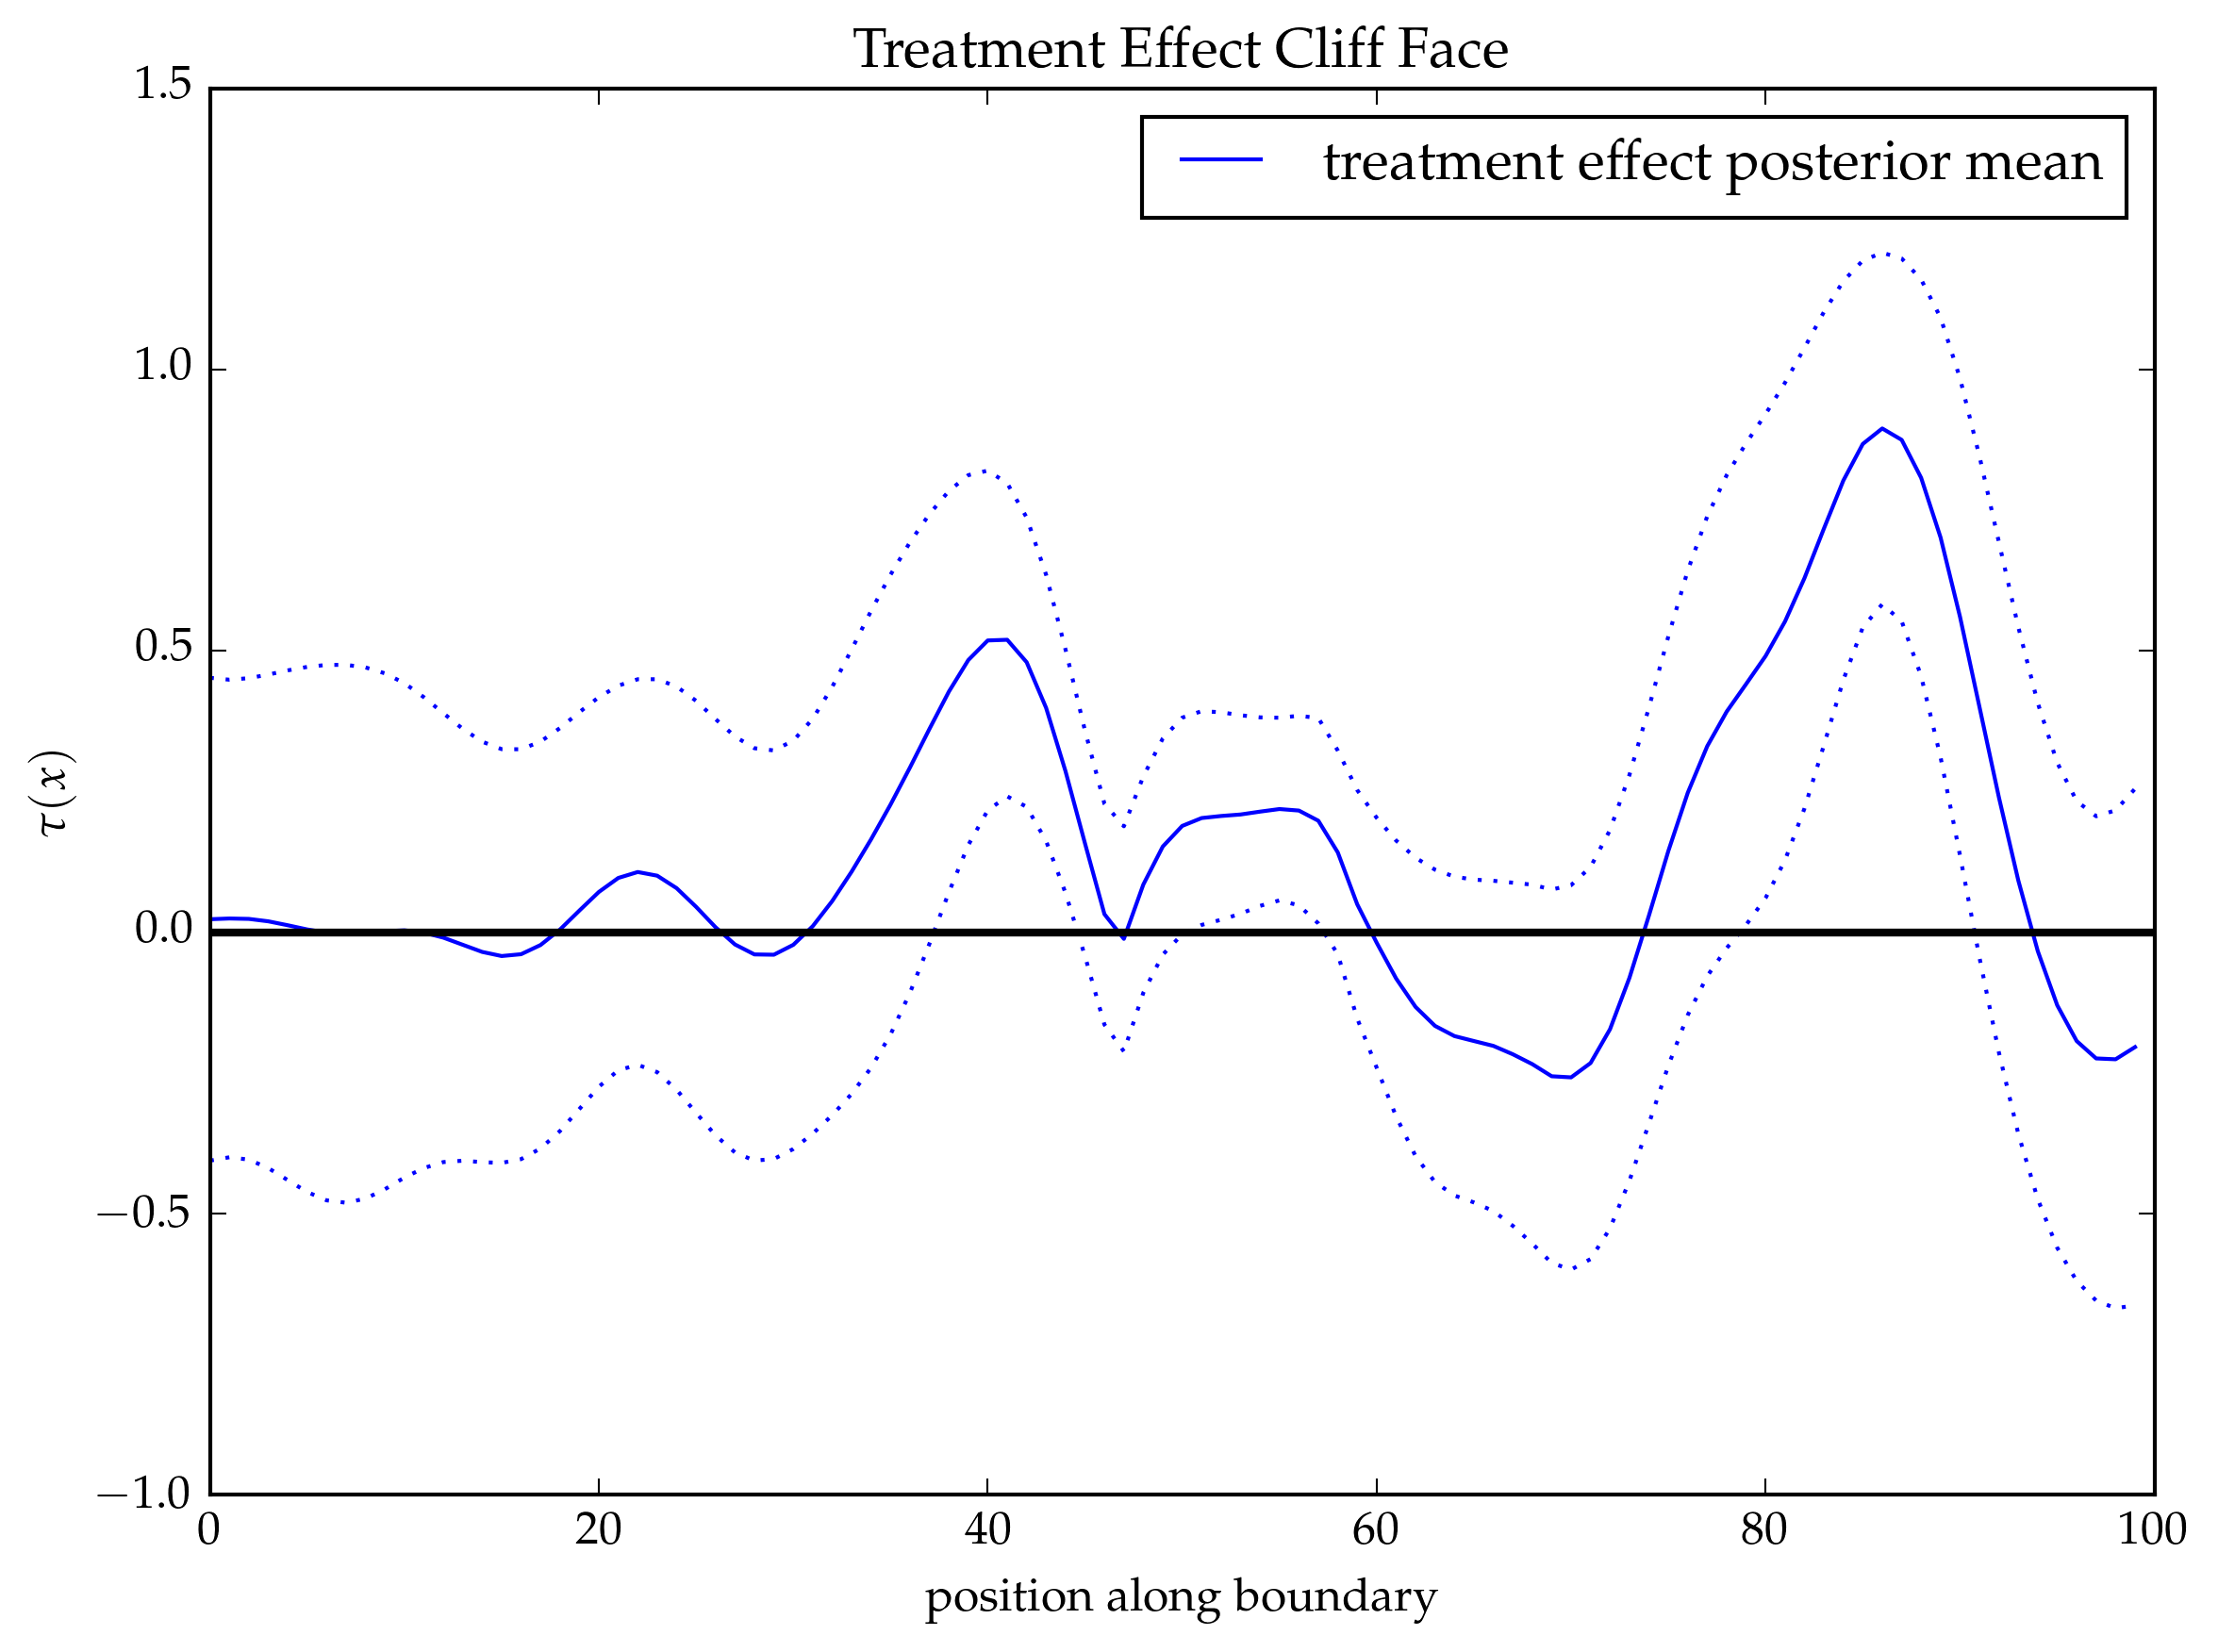

In [86]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

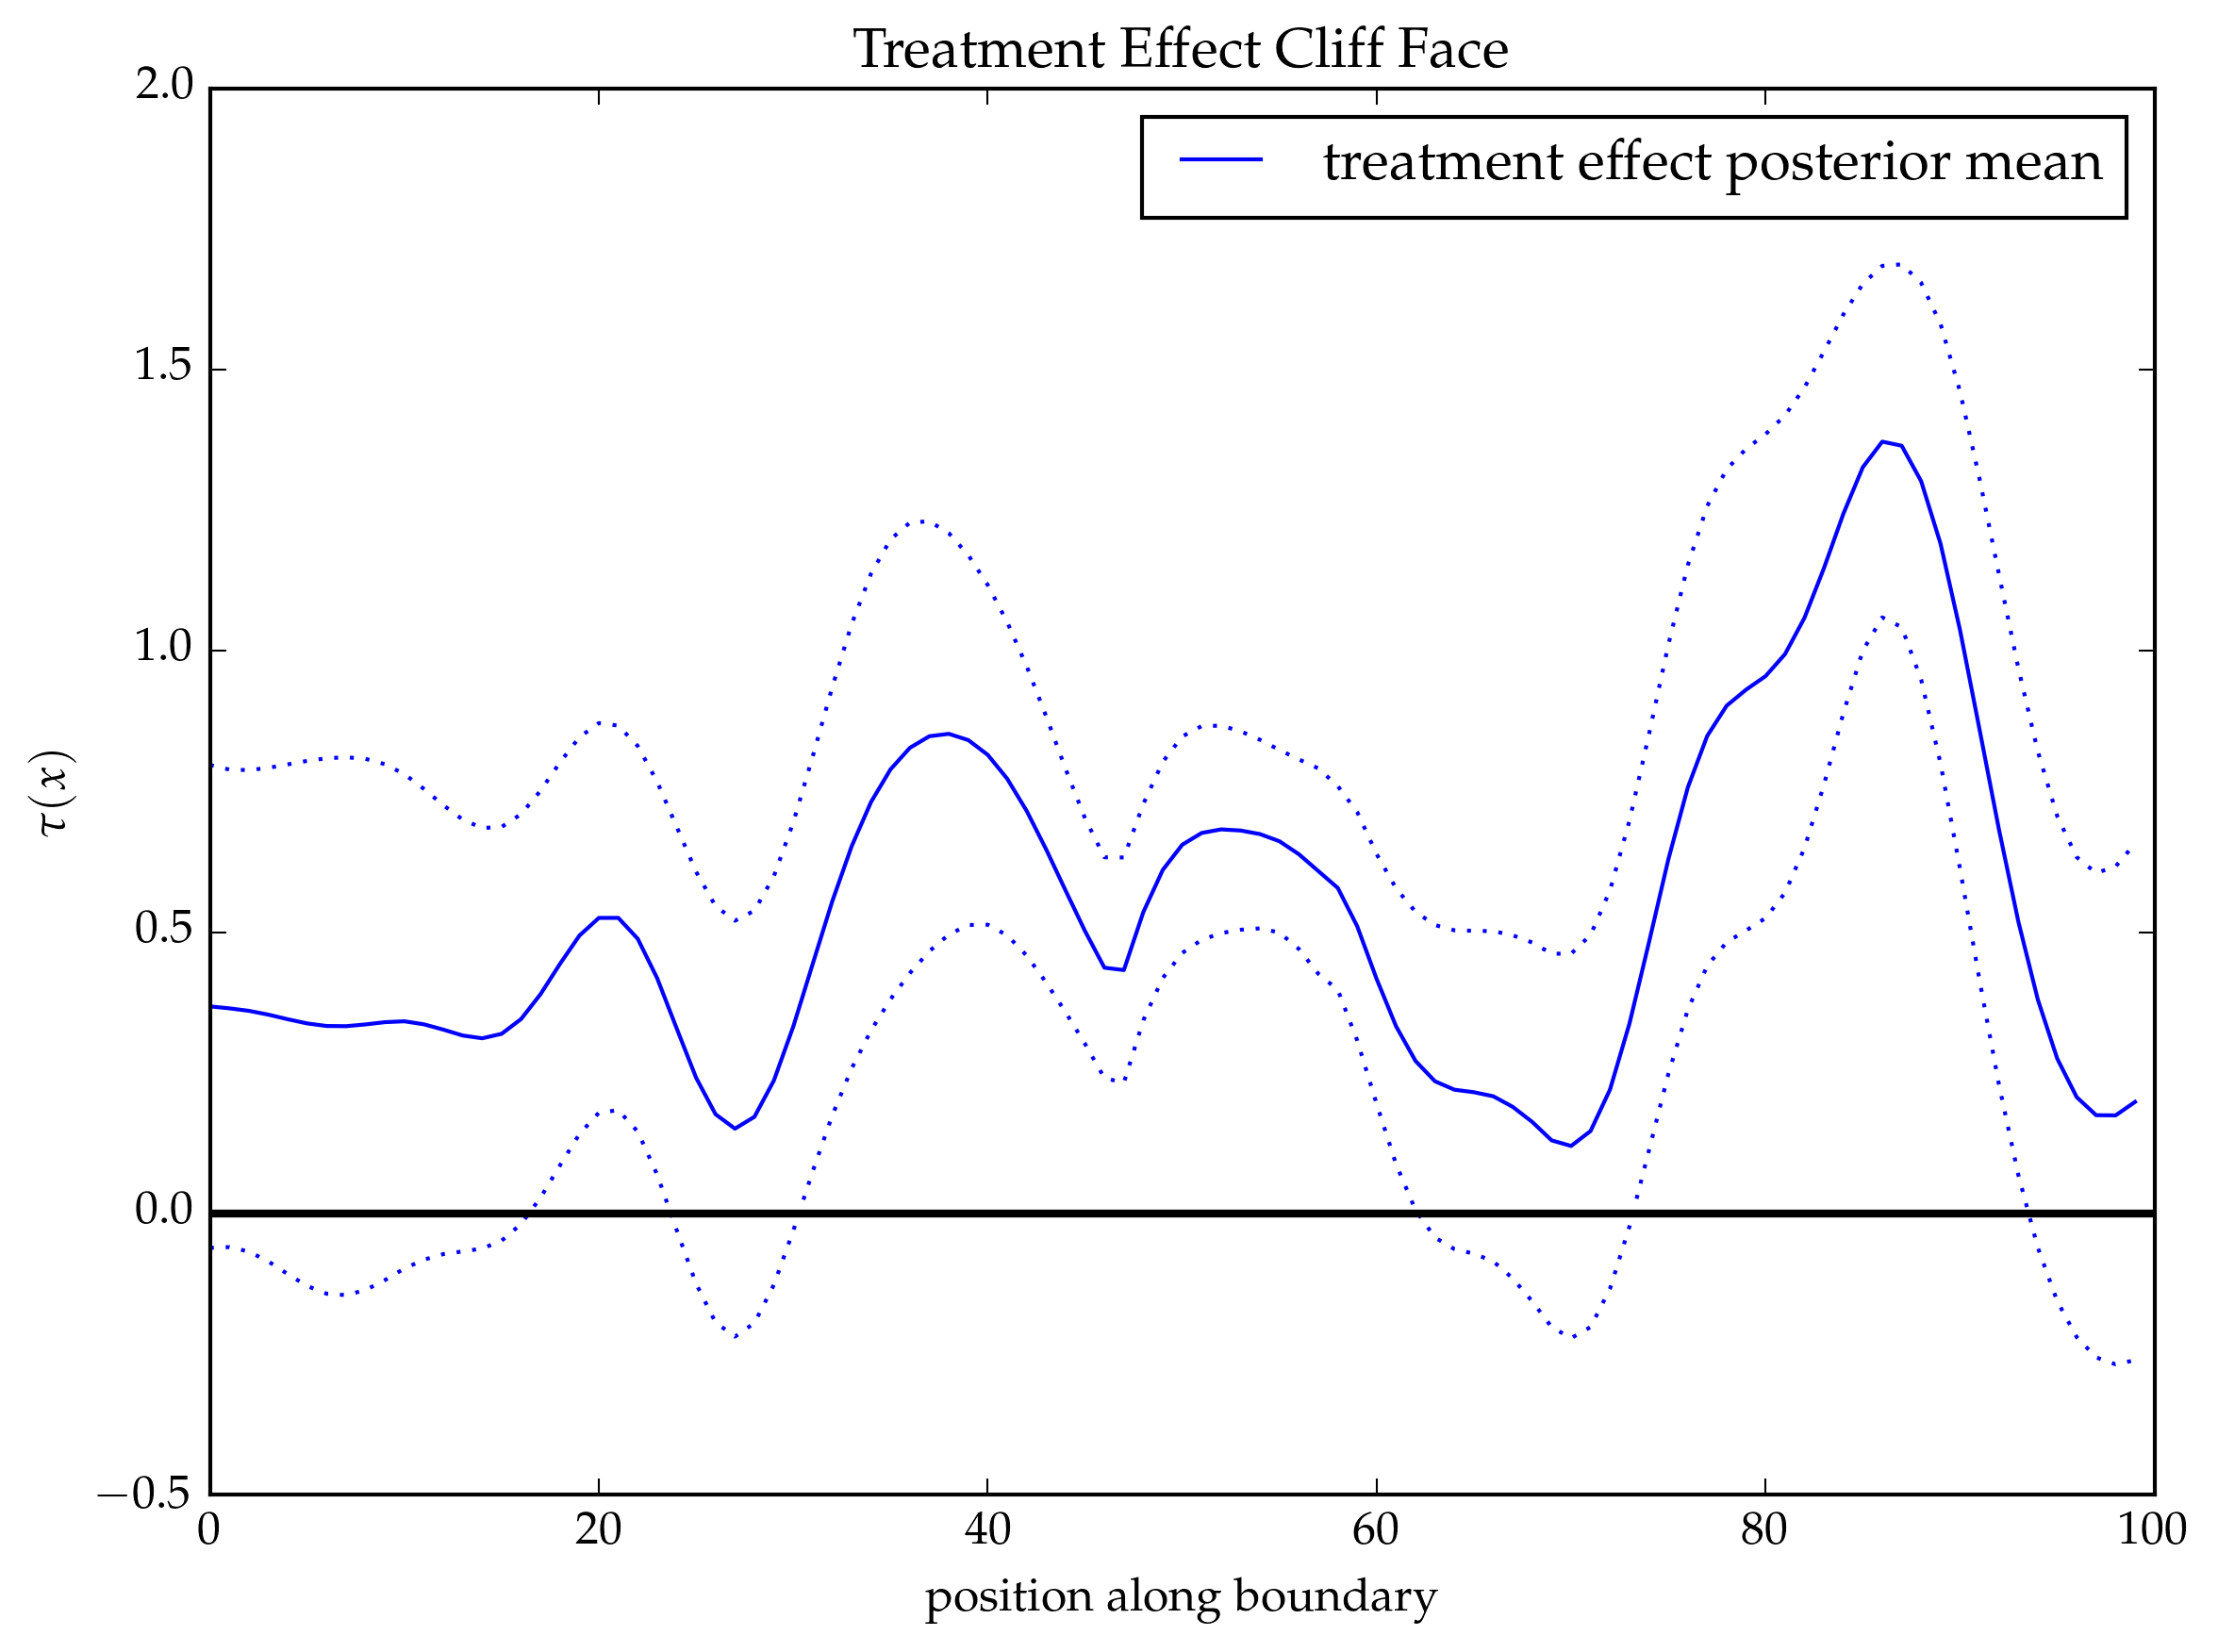

In [100]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [101]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.5431900415919968, σ=0.07995647747495001)